# Modelos estadísticos 20%

En cada uno de los siguientes ejercicios considere los siguientes pasos para construir sus modelos
predictivos. Debe realizar este procedimiento para las series: precio, retorno acumulado y volatilidad
para las diferentes ventanas (ω = 7,14,21,28)

## Definición de librerias, métricas y precisión del modelo

Procedemos inicialmente a cargar las librerias a utilizar, definir las métricas, definir cálculo de residuales, R2, Prueba de Ljung-Box y prueba de Jarque - Bera

In [129]:

import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
import statsmodels.api as sm
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import stattools
from statsmodels.stats.stattools import jarque_bera
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.graphics.tsaplots import plot_predict, plot_acf
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

def forecast_accuracy(forecast, actual, str_name, str_model, lj_lags = [10], window_str = ''):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))    # MAPE
    mae = np.mean(np.abs(forecast - actual))                      # MAE
    mse = np.mean((forecast - actual) ** 2)                       # MSE
    rmse = np.sqrt(mse)                                           # RMSE
    
    # Cálculo de los residuales
    residuals = actual - forecast

    # Cálculo del R²
    ss_res = np.sum((actual - forecast) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Prueba de Ljung-Box
    lb_test = acorr_ljungbox(residuals, lags=lj_lags, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # p-valor en el lag máximo especificado (10 en este caso)

    # Prueba de Jarque-Bera
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)

    df_acc = pd.DataFrame({
        'model': str_model,
        'window': window_str,
        'MAE': [mae],
        'MSE': [mse],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [lb_pvalue],
        'Jarque-Bera p-value': [jb_pvalue]
    }, index=[str_name])

    return df_acc


## Pruebas de hipótesis para independencia y normalidad

In [130]:
def independence_normality(residuals, nlags_ljbox):
    print('----- Test de Independencia  Ljung-Box --------')
  
    # Ho: no hay autocorrelación en los residuos
    acf_, confint_, qstat_, pvalues_ = stattools.acf(residuals, nlags=nlags_ljbox, qstat=True, alpha=0.05)
    alpha = 0.05
  
    for l, p_val in enumerate(pvalues_):
        if p_val > alpha:
            print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
        else:
            print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))
  
    print('----- Test de Normalidad  Jarque-Bera --------')

    # Jarque-Bera
    # Ho: los residuos tienen distribución normal
    JB, JBpv, skew, kurtosis = jarque_bera(residuals)

    if JBpv > alpha:
        print('Null hypothesis is accepted, residuos normales')
    else:
        print('Null hypothesis is rejected, residuos no normales')

    # Gráfico de la serie temporal de los residuos
    print('----- Grafico de serie de residuos --------')
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuos')
    plt.title('Serie Temporal de los Residuos')
    plt.xlabel('Fecha')
    plt.ylabel('Residuos')
    plt.legend()
    plt.show()

    # Q-Q Plot
    print('----- QQ Plot --------')
    qq = stats.probplot(residuals, dist="norm")
    teoricos = qq[0][0]  
    observados = qq[0][1] 

    plt.figure(figsize=(10, 6))
    plt.scatter(teoricos, observados, label='Observados')
    plt.plot(teoricos, teoricos, color='firebrick', linestyle='--', label='Línea de referencia')
    plt.title('Q-Q Plot de los Residuos')
    plt.xlabel('Teóricos')
    plt.ylabel('Observados')
    plt.legend()
    plt.show()

    print('----- ACF de Residuos --------')
    fig = plt.figure(figsize=(5.5, 5.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('ACF of Residuals')
    autocorrelation_plot(residuals, color='b', ax=ax)
    plt.show() 

## Entrenamiento, Validación y Test

In [131]:
def plot_model(train, val, test, y_pred, title):
    import pandas as pd
    import plotly.express as px
    from sklearn.metrics import mean_absolute_error

    # Preparación de los datos
    train_df = pd.DataFrame({
        'Time': train[-300:].index,
        'Value': train[-300:].values,
        'Category': 'Train'
    })
    val_df = pd.DataFrame({
        'Time': val.index,
        'Value': val.values,
        'Category': 'Validation'
    })
    test_df = pd.DataFrame({
        'Time': test.index,
        'Value': test.values,
        'Category': 'Test'
    })
    y_pred_df = pd.DataFrame({
        'Time': y_pred.index,
        'Value': y_pred.values,
        'Category': 'Prediction'
    })

    df = pd.concat([train_df, val_df, test_df, y_pred_df], axis=0)
    df['Dash'] = df['Category'].map({
        'Train': 'solid',
        'Validation': 'solid',
        'Test': 'solid',
        'Prediction': 'dash'
    })

    # Cálculo MAE
    mae = mean_absolute_error(test, y_pred)

    fig = px.line(
        df,
        x='Time',
        y='Value',
        color='Category',
        line_dash='Dash',
        title=f"{title}, MAE: {round(mae, 2)}",
        color_discrete_map={
            'Train': 'blue',
            'Validation': 'orange',
            'Test': 'green',
            'Prediction': 'red'
        }
    )

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='',
        template='plotly_white'
    )

    fig.show()
    
def train_val_test(df, window):
  size = len(df)
  train_len = size - 56 
  val_set_end = train_len + window
  test_set_end = val_set_end + window
  

  train_set = df[:train_len]
  val_set = df[train_len: val_set_end]
  test_set = df[val_set_end: test_set_end]

  return train_set, val_set, test_set

## Carga y Procesamiento de los Datos

In [132]:
data_init = pd.read_csv('https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv', sep=',')

df = data_init.copy(deep= True)
df = df[['Date', 'Price']]
df['Price'] = df['Price'].str.replace(',','')

df['Price'] = pd.to_numeric(df['Price'])
df['Date'] = pd.to_datetime(df['Date'])

df.index = df['Date']
df.drop('Date', axis=1, inplace=True)

df = df.sort_index(ascending= True)
df_copy = df.copy(deep= True)
df.reset_index(drop=True, inplace=True)

timeserie = df["Price"]

px.line(df, x= df.index,  y = df['Price'])

## Modelamiento y ajuste

###  Simple Exponential Smoothing (Sin Librería)

In [133]:
# Definición de horizontes

windows = [7,14,21,28]
model_summary  = pd.DataFrame()

# Función de Suavizado Exponencial Simple 
def firstsmooth(y, alpha, start=None):
    if len(y) == 0:
        raise ValueError("Empty training serie.")
        
    ytilde = y.copy()
    if start is None:
        start = y.iloc[0]
    ytilde.iloc[0] = alpha * y.iloc[0] + (1 - alpha) * start
    for i in range(1, len(y)):
        ytilde.iloc[i] = alpha * y.iloc[i] + (1 - alpha) * ytilde.iloc[i - 1]
    return ytilde

# Generar predicciones basadas en el último valor suavizado
def ses_forecast(train, val_length, alpha, start=None):
    # Aplicar SES al conjunto de entrenamiento
    ytilde = firstsmooth(train, alpha, start)
    if len(ytilde) == 0:
        raise ValueError("Empty training serie.")
        
    last_smoothed = ytilde.iloc[-1]
    
    # Generar predicciones para el conjunto de validación
    y_pred = [last_smoothed] * val_length
    return y_pred

# Optimizador 
def ses_optimizer(train, val, alphas):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        y_pred = ses_forecast(train, len(val), alpha)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    return best_alpha, best_mae

def ses_model_tuning(train, val):
    alphas = [round(a, 2) for a in list(np.arange(0.2, 1, 0.2))]
    best_alpha, best_mae = ses_optimizer(train, val, alphas)
    return best_alpha

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE       7  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

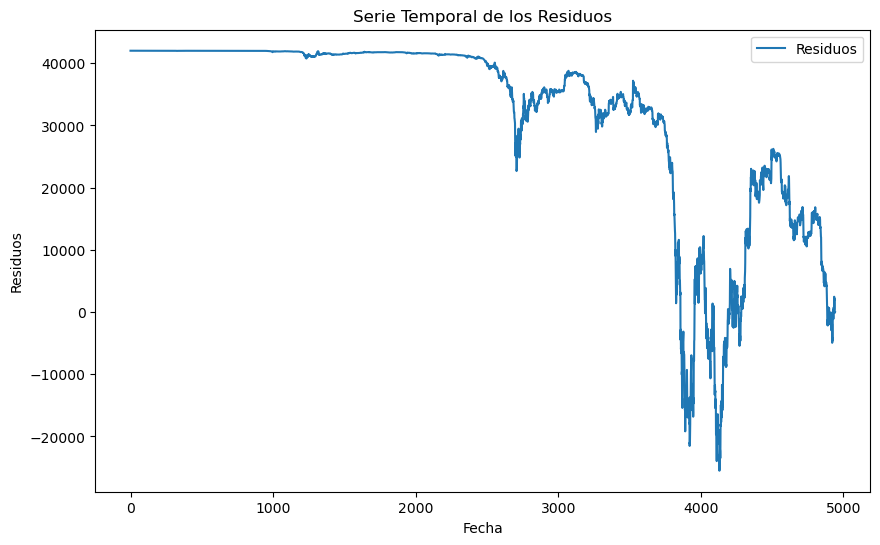

----- QQ Plot --------


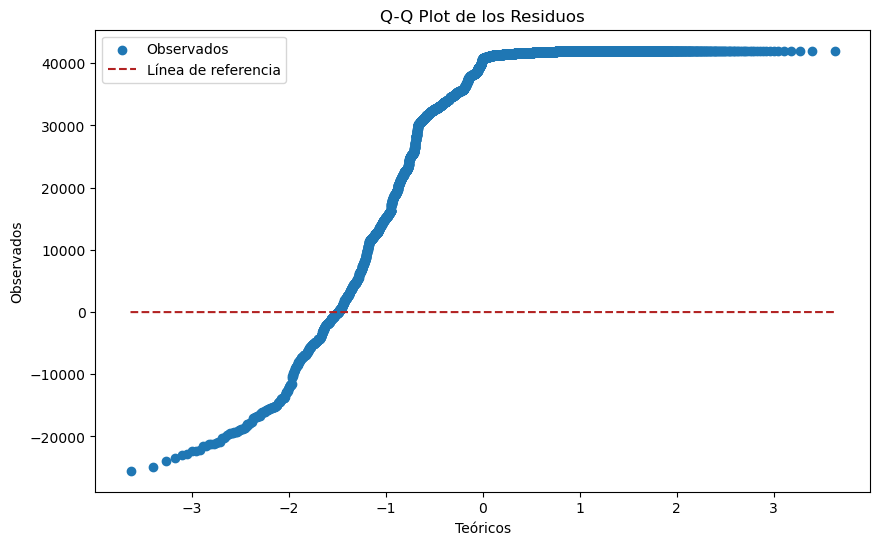

----- ACF de Residuos --------


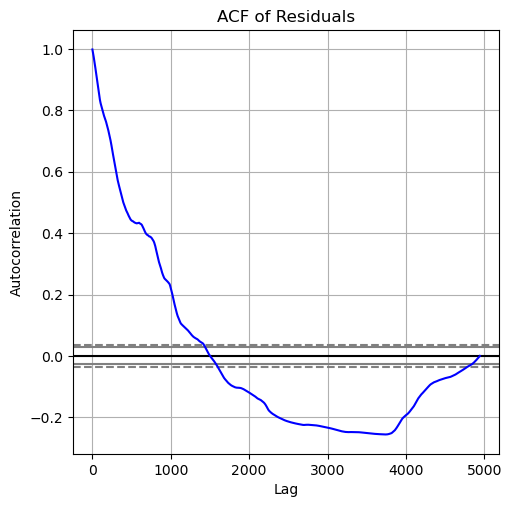

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE      14  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

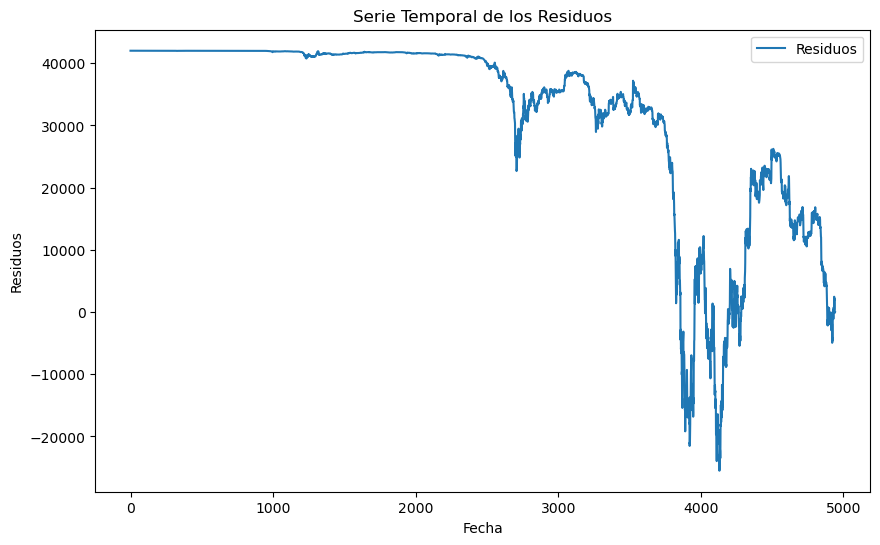

----- QQ Plot --------


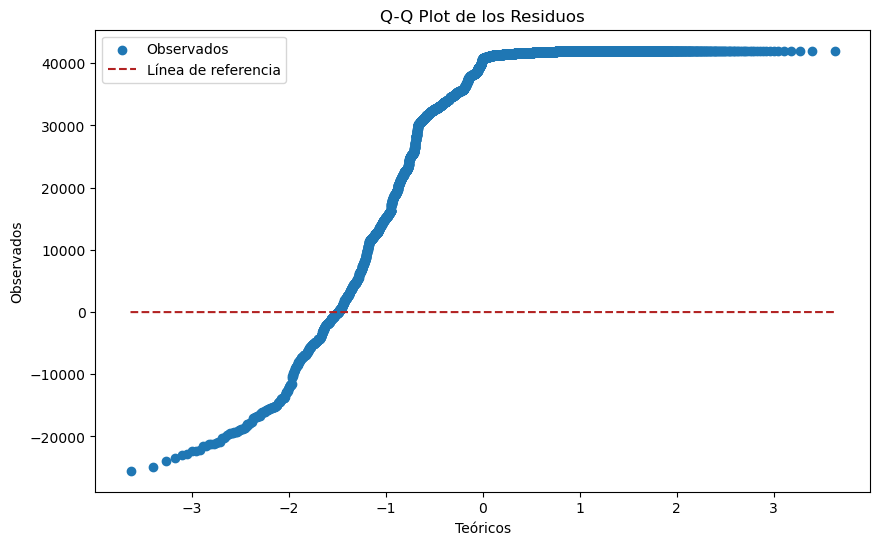

----- ACF de Residuos --------


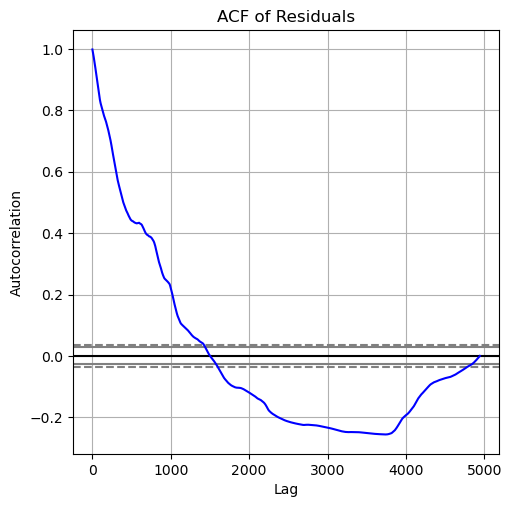

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE      21  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

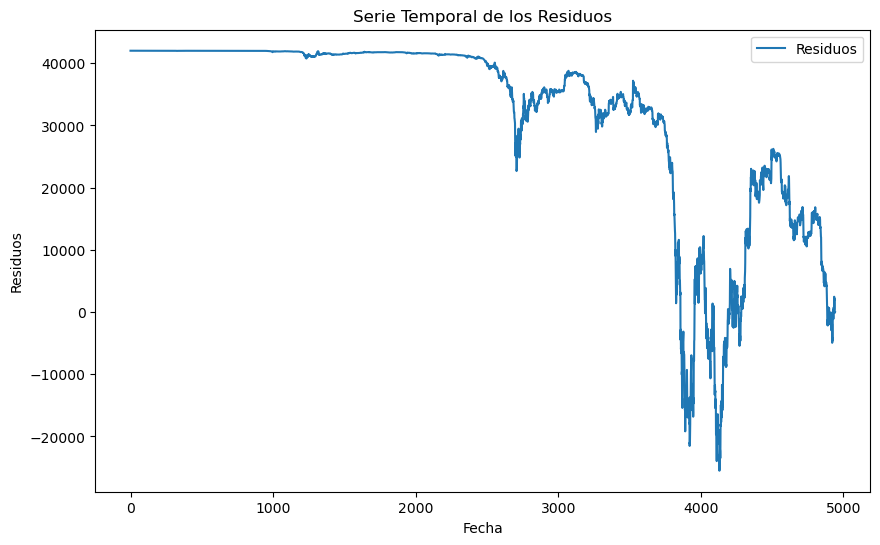

----- QQ Plot --------


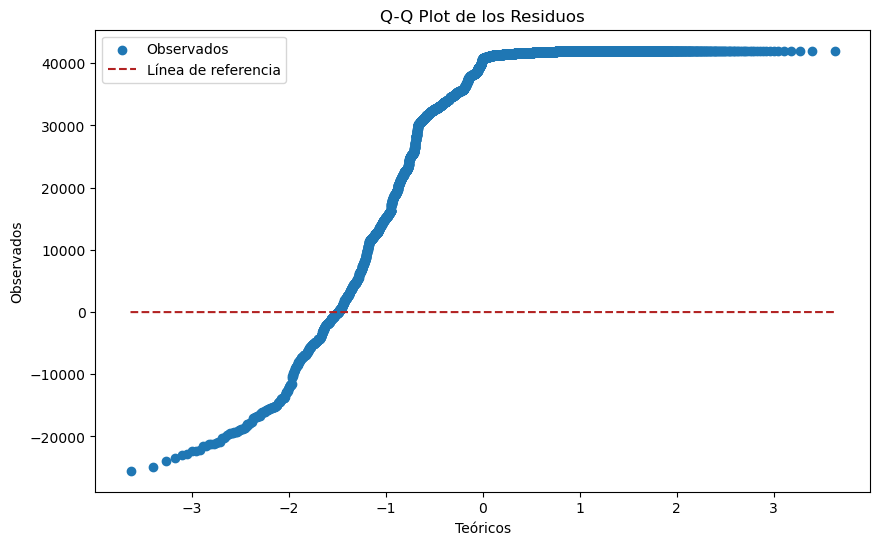

----- ACF de Residuos --------


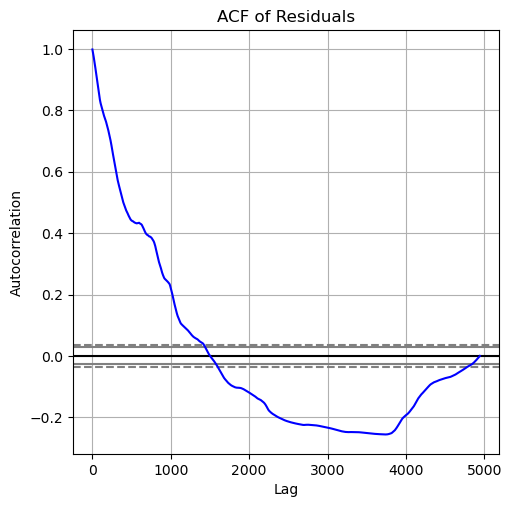

      model  window           MAE           MSE        MAPE          RMSE  \
train   SSE      28  32900.611982  1.236833e+09  13411.5969  35168.642882   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4.377388                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

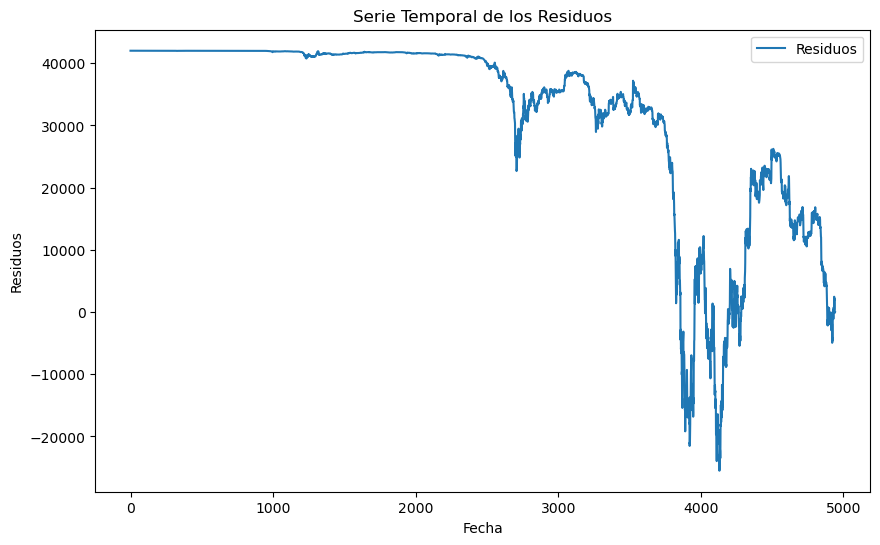

----- QQ Plot --------


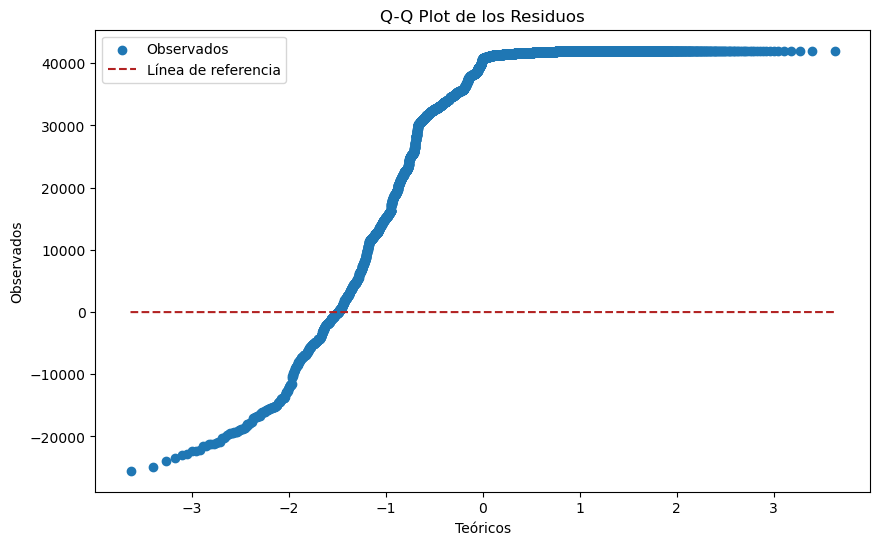

----- ACF de Residuos --------


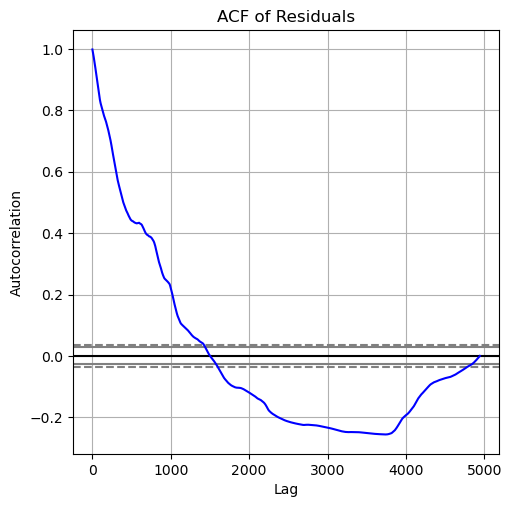

In [134]:
# ENTRENAMIENTO

best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning(train, val)
    best_params.append({'window': window, 'alpha': best_alpha})
    
for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = ses_forecast(train,len(train),param['alpha'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'SSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

Para evaluar la eficacia del modelo de suavización exponencial en el conjunto de entrenamiento, se examinaron diferentes métricas de error:

1. *Error Absoluto Medio (MAE):* Con un valor cercano a 32,9, el MAE indica la magnitud promedio del error absoluto entre los valores reales y las predicciones generadas por el modelo. Este resultado implica la media de la desviación en unidades de la serie temporal.

2. *Error Cuadrático Medio (MSE):* Con un valor significativamente alto, el MSE sugiere una alta variabilidad en los errores. Este indicador es particularmente sensible a errores grandes, ya que eleva al cuadrado las desviaciones, aumentando la penalización en casos de errores más sustanciales.

3. *Raíz del Error Cuadrático Medio (RMSE):* Con un valor de 35,18, el RMSE brinda una medida de la desviación estándar de los errores. 

4. *Error Porcentual Absoluto Medio (MAPE):* Con un MAPE de 13,41 %, se presenta un error porcentual promedio considerable. Esto señala que el modelo tiene una precisión limitada en la serie temporal, particularmente en instantes donde los valores reales muestran alta variabilidad.

**Para validar la adecuación de los residuos generados por el modelo de suavización exponencial, se implementaron dos pruebas estadísticas esenciales:**

* Prueba de Ljung-Box: Esta prueba investiga la independencia de los residuos. Los resultados revelan que se rechaza la hipótesis nula de independencia en los primeros 10 rezagos, con un valor p de 0.0 en cada caso. Esto indica una autocorrelación significativa en los residuos, sugiriendo que el modelo no captura completamente las dependencias temporales presentes en la serie.

* Prueba de Normalidad de Jarque-Bera: Se utiliza esta prueba para confirmar si los residuos se distribuyen normalmente. Con un valor p de 0.0, se rechaza la hipótesis nula de normalidad, lo que implica que los residuos no siguen una distribución normal. Este resultado puede indicar un déficit en la captura de ciertos patrones en los datos.

**Los gráficos obtenidos proporcionan información adicional sobre el comportamiento de los residuos del modelo:**

* Serie Temporal de Residuos: La gráfica representa las fluctuaciones y variaciones notables en los residuos a lo largo del tiempo. En algunos momentos, se aprecian desviaciones abruptas, sugiriendo que hay eventos o patrones que el modelo de suavización exponencial no logra captar adecuadamente.

* Gráfico Q-Q de Residuos: Este gráfico pone de manifiesto que los residuos se desvían considerablemente de la línea teórica de normalidad, en particular en los extremos. Este hallazgo respalda la conclusión de la prueba de Jarque-Bera, evidenciando que los residuos no siguen una distribución normal.

* Función de Autocorrelación (ACF) de Residuos: La ACF revela una clara tendencia de autocorrelación positiva en los primeros rezagos, aunque disminuye gradualmente. No obstante, algunos picos que se encuentran fuera de los intervalos de confianza sugieren que persisten patrones en los residuos que no han sido adecuadamente modelados.

* En conclusión, los resultados sugieren que el modelo de suavización exponencial enfrenta limitaciones para capturar completamente los patrones temporales de la serie, lo cual se refleja en los altos valores de error y la falla de las pruebas de independencia y normalidad aplicadas a los residuos.

In [135]:
# TEST

for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = ses_forecast(to_train, len(test), param['alpha'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    print(pred.shape)
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window          MAE           MSE      MAPE         RMSE       R2  \
test   SSE       7  2839.335976  1.242245e+07  0.060405  3524.549638 -1.84878   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.009841               0.6969  
(7, 1)


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      14  3332.601755  1.168448e+07  0.064547  3418.256446   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -19.206875            0.47835             0.137768  
(14, 1)


     model  window          MAE           MSE      MAPE          RMSE  \
test   SSE      21  8005.921852  1.041354e+08  0.123616  10204.676767   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -1.319757       4.509490e-10             0.328286  
(21, 1)


     model  window          MAE           MSE      MAPE          RMSE  \
test   SSE      28  14136.84777  2.180818e+08  0.211357  14767.593779   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -10.961906           0.000002             0.427015  
(28, 1)


En el análisis del conjunto de pruebas para el modelo de suavización exponencial utilizando diferentes tamaños de ventana, se identifican los siguientes patrones:

* Ventana de 7:

Las métricas de error son relativamente bajas en comparación con otros tamaños de ventana, lo que sugiere un mejor rendimiento en términos de error absoluto y cuadrático. 
El coeficiente de determinación ( R^2 ) presenta un valor negativo, lo que indica una capacidad explicativa limitada del modelo en este conjunto de pruebas.
La prueba de Ljung-Box no permite rechazar la hipótesis de independencia de los residuos, lo cual es positivo para la validez del modelo.
La prueba de Jarque-Bera no rechaza la normalidad de los residuos, indicando un comportamiento razonablemente adecuado en términos de distribución.

* Ventana de 14:

Las métricas de error aumentan en comparación con la ventana de 7, sugiriendo una disminución en la precisión del ajuste.
El valor de ( R^2 ) permanece negativo, evidenciando una falta de ajuste adecuado.
La prueba de Ljung-Box muestra un valor p más bajo, acercándose a umbrales que podrían indicar correlación en los residuos, aunque no es concluyente.
La prueba de Jarque-Bera sigue sin rechazar la normalidad, lo que sugiere que los residuos mantienen una distribución aceptable.

* Ventana de 21:

Las métricas de error mejoran ligeramente en comparación con la ventana de 14, aunque siguen siendo más altas que las de la ventana de 7.
El ( R^2 ) continúa siendo negativo, pero experimenta una mejora con respecto a la ventana anterior.
La prueba de Ljung-Box presenta un valor p menor, acercándose a un rango de rechazo, lo que podría sinalar posible autocorrelación en los residuos.
La prueba de Jarque-Bera indica que los residuos tienen una distribución razonablemente normal.
Ventana de 28:

Las métricas de error son las más elevadas entre todas las ventanas, lo que sugiere un ajuste poco preciso en el conjunto de pruebas.
El ( R^2 ) sigue siendo negativo y bajo, lo que refuerza la conclusión de un ajuste deficiente.
La prueba de Ljung-Box rechaza la independencia de los residuos, lo que señala autocorrelación y posibles problemas en el modelo.
La prueba de Jarque-Bera no rechaza la normalidad, lo que indica que, a pesar de la autocorrelación, los residuos no presentan una desviación significativa respecto a la normalidad en su distribución.
En resumen, los tamaños de ventana más pequeños tienden a generar mejores resultados en las métricas de error, sugiriendo un ajuste más preciso. Sin embargo, el modelo evidencia limitaciones en su capacidad explicativa en el conjunto de prueba.

###  Simple Exponential Smoothing (Statsmodels)

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT       7  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

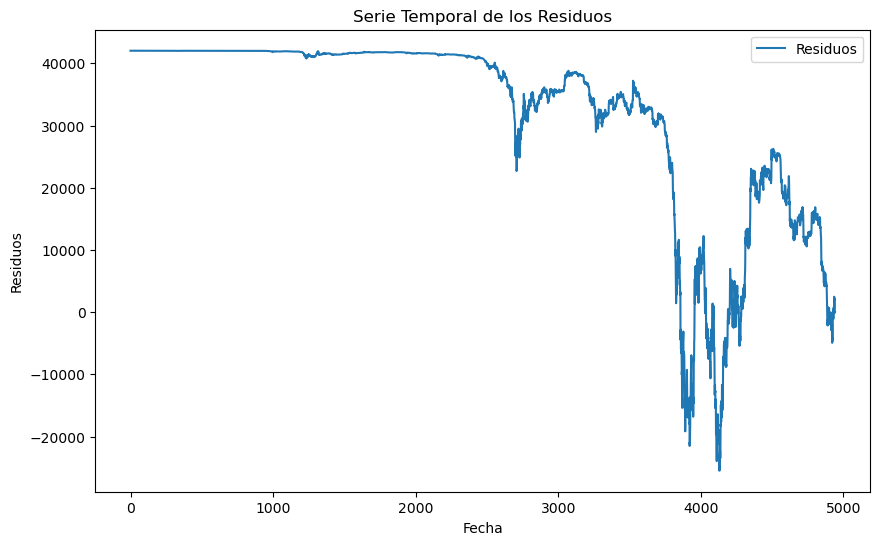

----- QQ Plot --------


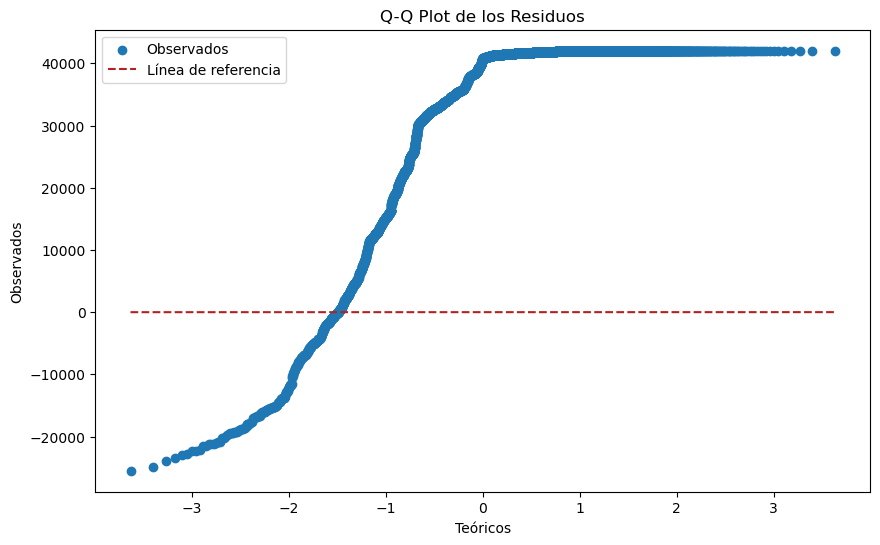

----- ACF de Residuos --------


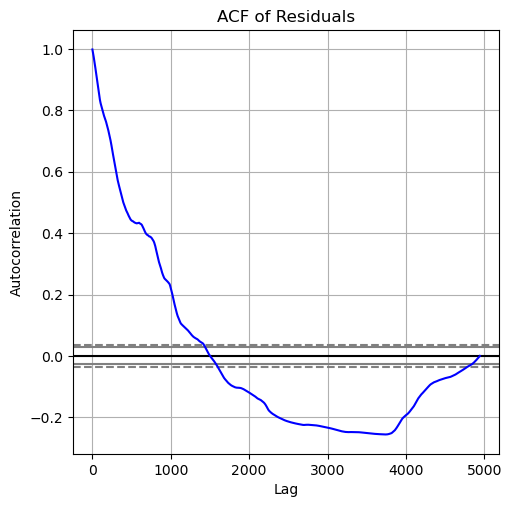

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT      14  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

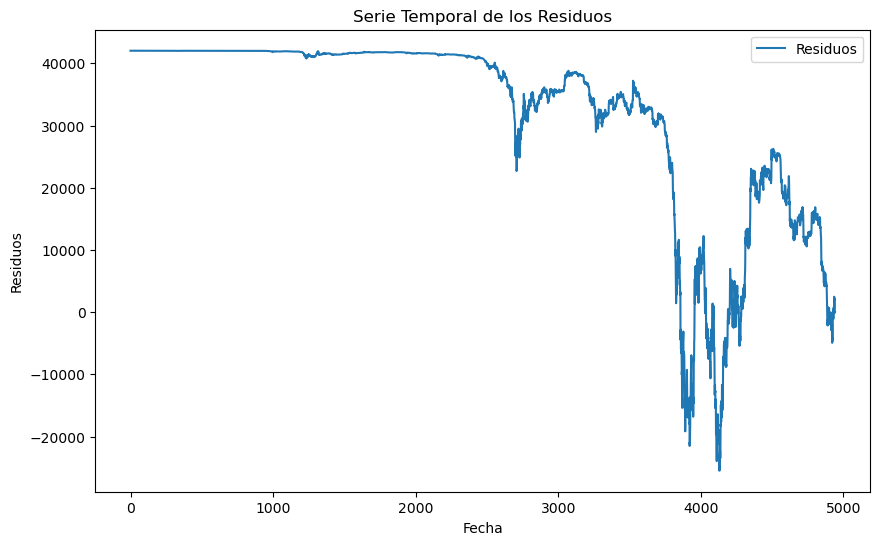

----- QQ Plot --------


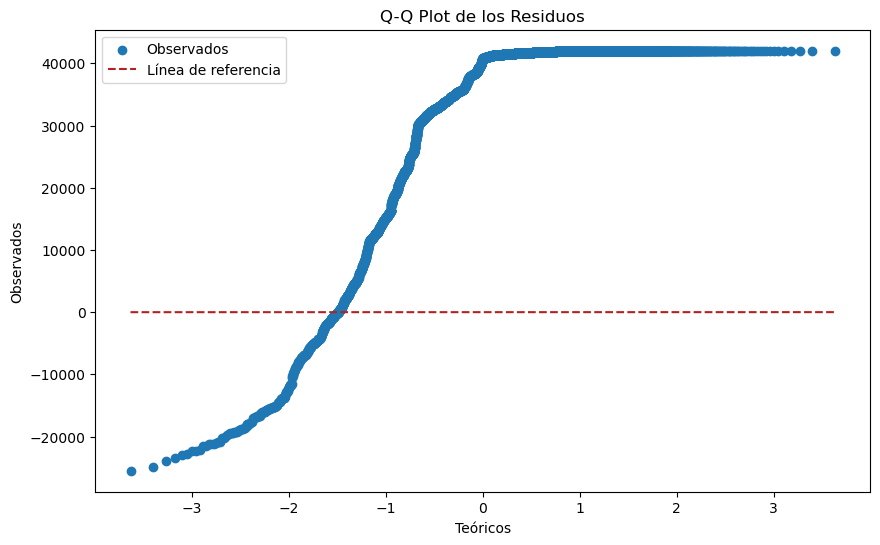

----- ACF de Residuos --------


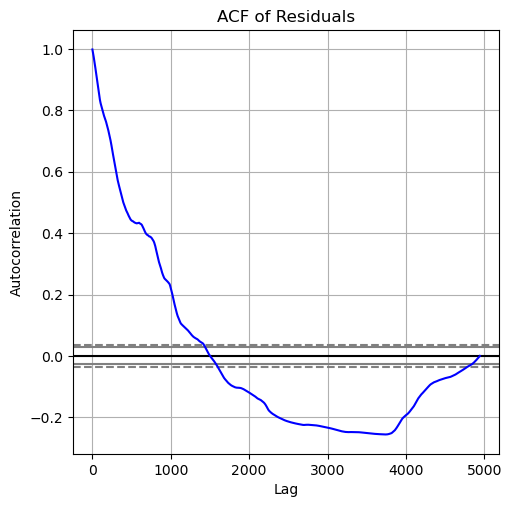

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT      21  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

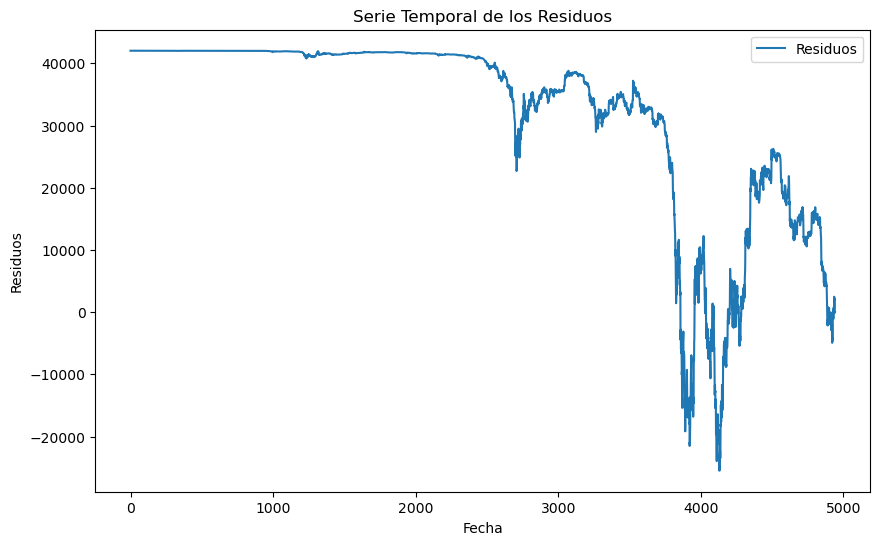

----- QQ Plot --------


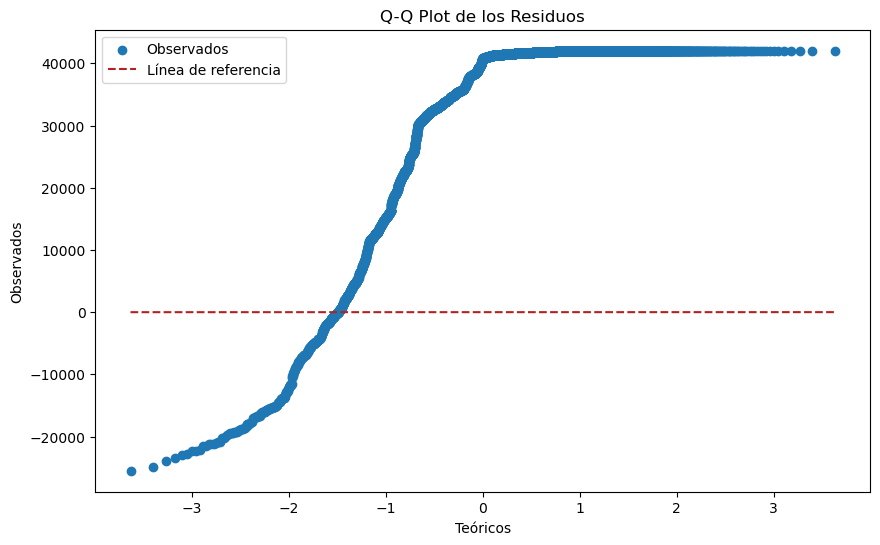

----- ACF de Residuos --------


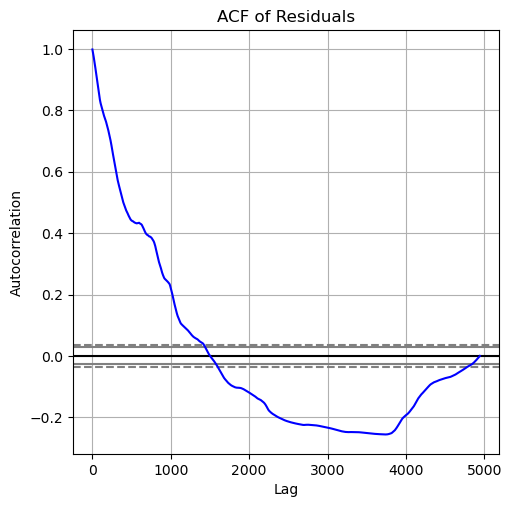

          model  window           MAE           MSE          MAPE  \
train  SSE_STAT      28  32912.037778  1.237673e+09  13415.818966   

               RMSE        R2  Ljung-Box p-value  Jarque-Bera p-value  
train  35180.578012 -4.381039                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

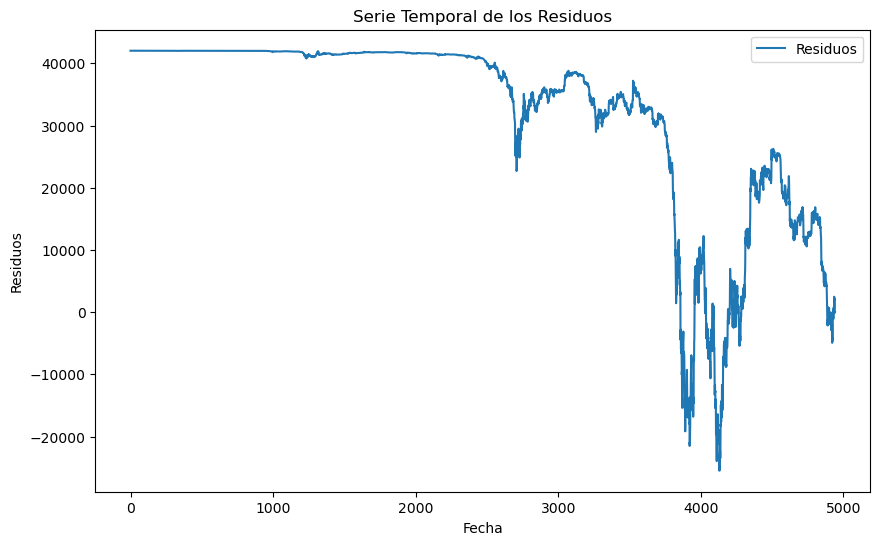

----- QQ Plot --------


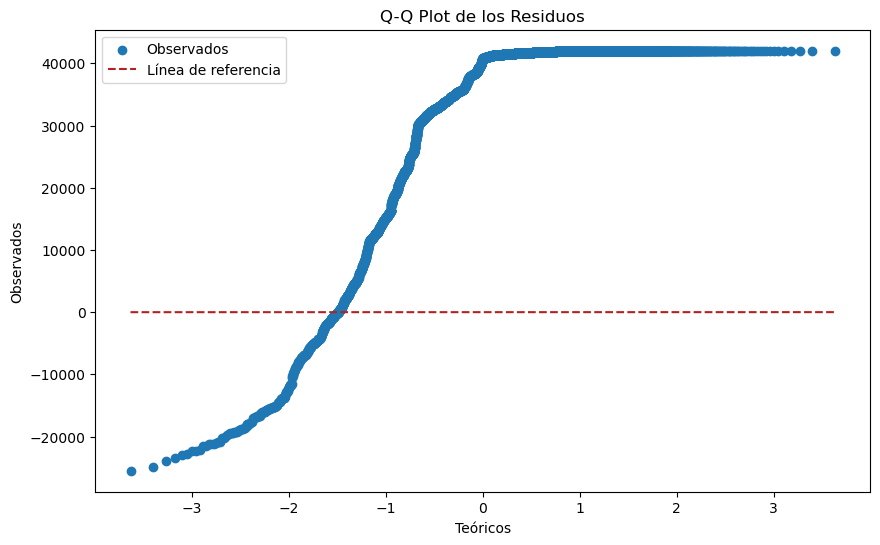

----- ACF de Residuos --------


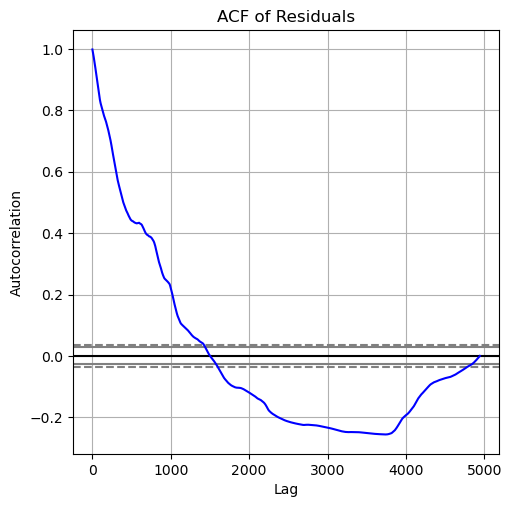

In [136]:

def ses_optimizer_stat(train, val, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)


        if mae < best_mae:
            best_alpha, best_mae = alpha, mae          

    return best_alpha, best_mae

def ses_model_tuning_stat(train, val):
    
    alphas = np.arange(0.2, 1, 0.1)

    #best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=step)
    best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=len(val))   
        #return y_pred, final_model, residuals 
    return best_alpha 

best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning_stat(train,val)
    best_params.append({'window': window, 'alpha': best_alpha})
    
# ENTRENAMIENTO

for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    model = SimpleExpSmoothing(train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(train))
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

Las métricas de error (MAE, MSE, MAPE, RMSE) presentan valores altos, lo que señala un significativo nivel de inexactitud en las predicciones. Esto indica que el modelo no logra captar adecuadamente la estructura inherente a los datos del conjunto de entrenamiento.

*Evaluaciones de Diagnóstico de Residuos:*

* Ljung-Box: La hipótesis nula de independencia se rechaza en todos los rezagos analizados, lo que sugiere la presencia de una autocorrelación notable en los residuos. Esto indica que el modelo no ha logrado identificar las relaciones temporales, lo que se traduce en residuos con patrones no incluidos.
* Jarque-Bera: La prueba de normalidad resulta desfavorable, sugiriendo que los residuos no se distribuyen de forma normal, lo que puede comprometer la fiabilidad del modelo en la estimación de intervalos de predicción.

**Los gráficos producidos proporcionan información adicional sobre el comportamiento de los residuos generados por el modelo:**

* Serie Temporal de Residuos: La representación gráfica de la serie temporal ilustra fluctuaciones y variaciones notables en los residuos a lo largo del tiempo. En varios momentos, se aprecian desviaciones drásticas, lo que indica la existencia de eventos o patrones que el modelo de suavización exponencial no consigue capturar adecuadamente.

* Gráfico Q-Q de Residuos: Este gráfico muestra que los residuos se apartan significativamente de la línea de referencia teórica de normalidad, especialmente en los extremos. Esto respalda la conclusión de la prueba de Jarque-Bera, confirmando que los residuos no siguen una distribución normal.

* Función de Autocorrelación (ACF) de Residuos: La ACF revela una clara inclinación hacia la autocorrelación positiva en los primeros rezagos, la cual disminuye de manera gradual. Sin embargo, ciertos picos que caen fuera de los intervalos de confianza sugieren que permanecen patrones en los residuos que no fueron adecuadamente modelados.

En conclusión, los resultados evidencian que el modelo de suavización exponencial tiene limitaciones en su capacidad para capturar completamente los patrones temporales de la serie. Esto se manifiesta en los altos niveles de error y en las fallas de los tests de independencia y normalidad aplicados a los residuos.

In [137]:
# TEST

for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    model = SimpleExpSmoothing(to_train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(test))
    metrics = forecast_accuracy(pred.values,test, 'test', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    plot_model(train,val,test,pred,title='SSE')

         model  window          MAE           MSE      MAPE         RMSE  \
test  SSE_STAT       7  2886.010934  1.268968e+07  0.061433  3562.257778   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -1.910062           0.009841               0.6969  


         model  window         MAE           MSE      MAPE         RMSE  \
test  SSE_STAT      14  3247.08804  1.112182e+07  0.062885  3334.939791   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -18.233834            0.47835             0.137768  


         model  window          MAE           MSE      MAPE          RMSE  \
test  SSE_STAT      21  7990.938124  1.035984e+08  0.123411  10178.331907   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -1.307795       4.509490e-10             0.328286  


         model  window           MAE           MSE      MAPE         RMSE  \
test  SSE_STAT      28  14101.769432  2.170913e+08  0.210821  14734.01718   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -10.907573           0.000002             0.427015  


* Ventana de 7:

Métricas de Error: Los errores son moderados, evidenciando un MAPE bajo, lo que sugiere un nivel de error relativo aceptable.
R²: Presenta un valor negativo, lo que indica que el modelo no se adapta bien a los datos.
Evaluaciones de Diagnóstico: La prueba de Ljung-Box indica la presencia de autocorrelación en los residuos, mientras que Jarque-Bera muestra que los residuos son aproximadamente normales.

* Ventana de 14:

Métricas de Error: Se nota una mejora en las métricas, con un MAPE bajo y una disminución en los errores absolutos.
R²: El valor es negativo y se aproxima a cero, lo que sugiere un ajuste inadecuado.
Evaluaciones de Diagnóstico: La prueba de Ljung-Box no indica autocorrelación significativa, y Jarque-Bera señala que los residuos están próximos a una distribución normal.

* Ventana de 21:

Métricas de Error: Los errores han aumentado considerablemente, resultando en un MAPE relativamente alto.
R²: Continúa siendo negativo, lo que es indicativo de un mal ajuste.
Evaluaciones de Diagnóstico: La prueba de Ljung-Box revela autocorrelación significativa en los residuos, mientras que Jarque-Bera no rechaza la normalidad de estos.

* Ventana de 28:

Métricas de Error: Los errores son elevados, lo que refleja las dificultades del modelo para capturar adecuadamente la estructura en esta ventana de datos.
R²: Se mantiene en un valor negativo, indicando un ajuste deficiente.
Evaluaciones de Diagnóstico: Ljung-Box sugiere una fuerte autocorrelación, mientras que Jarque-Bera indica que los residuos son aproximadamente normales.

En general, el modelo presenta un ajuste insatisfactorio a lo largo de las diferentes ventanas de datos, con errores altos y evidencia de autocorrelación en los residuos, especialmente en las ventanas más amplias. Aunque los residuos se acercan a la normalidad, sería beneficioso considerar ajustes adicionales o la implementación de métodos alternativos para mejorar la precisión y capturar de manera más efectiva la estructura de los datos.

### Double Exponencial Smoothing

      model  window           MAE           MSE        MAPE          RMSE  \
train   DSE       7  44415.930974  2.092572e+09  13907.2858  45744.639238   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
train -8.097888                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos

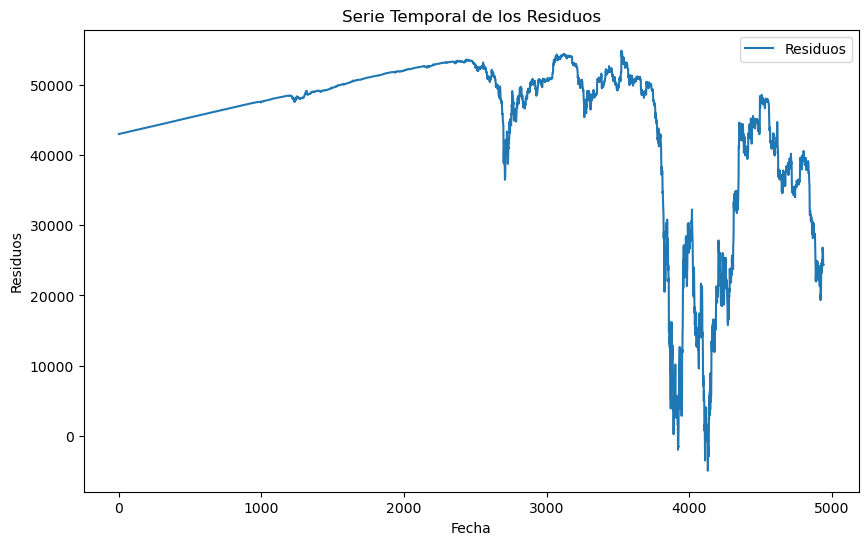

----- QQ Plot --------


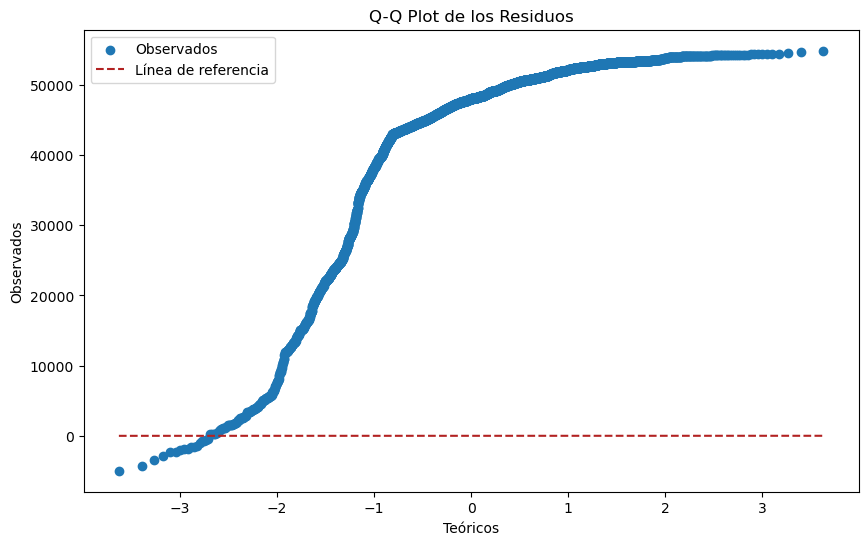

----- ACF de Residuos --------


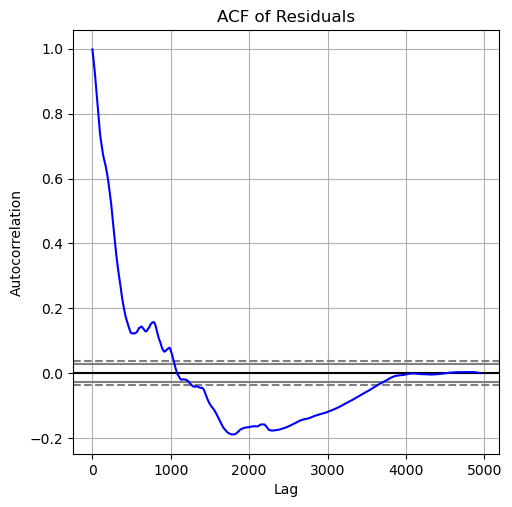

      model  window            MAE           MSE          MAPE         RMSE  \
train   DSE      14  857320.849944  9.515629e+11  26552.205167  975480.8476   

                R2  Ljung-Box p-value  Jarque-Bera p-value  
train -4136.115605                0.0         2.910762e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie d

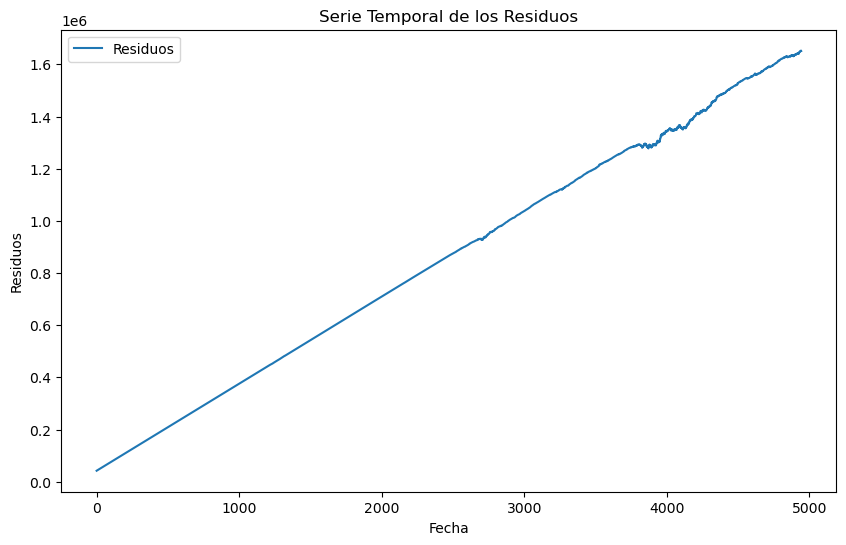

----- QQ Plot --------


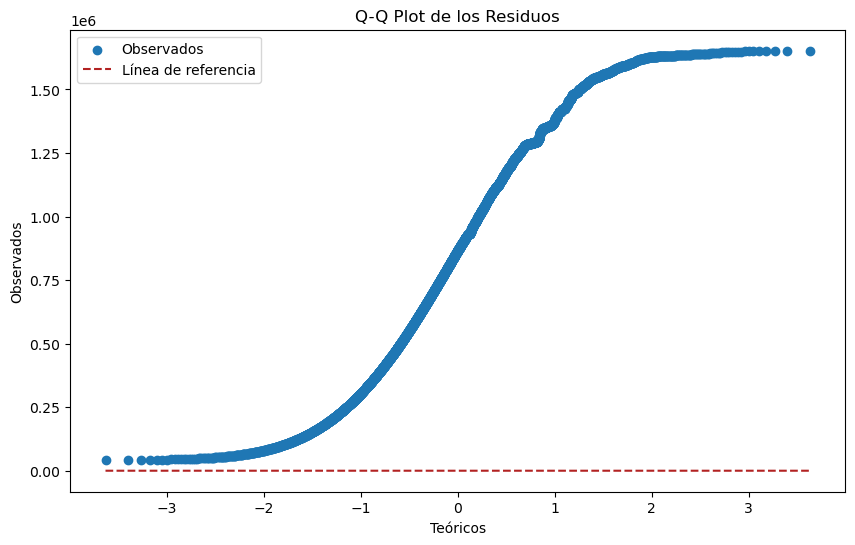

----- ACF de Residuos --------


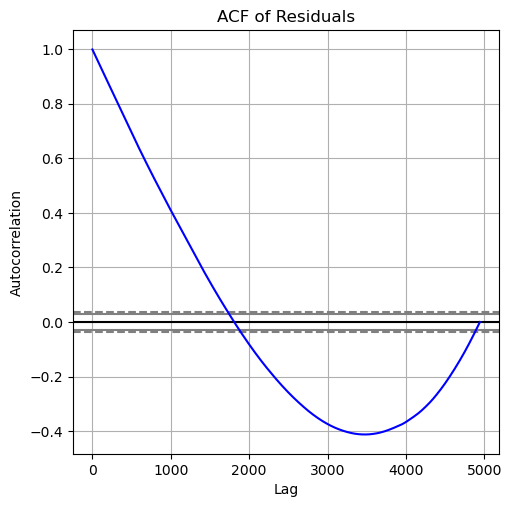

      model  window           MAE           MSE          MAPE          RMSE  \
train   DSE      21  1.342343e+06  2.358015e+12  34081.410632  1.535583e+06   

                 R2  Ljung-Box p-value  Jarque-Bera p-value  
train -10250.954264                0.0         1.371897e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie

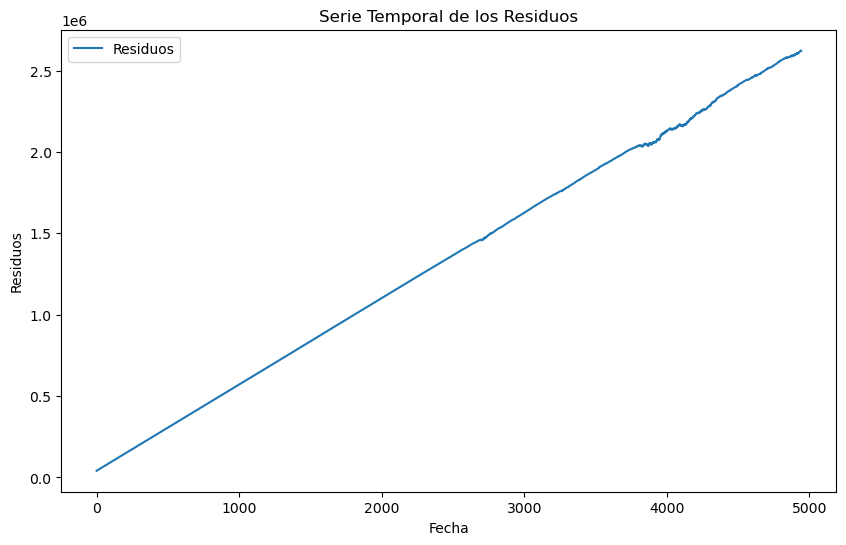

----- QQ Plot --------


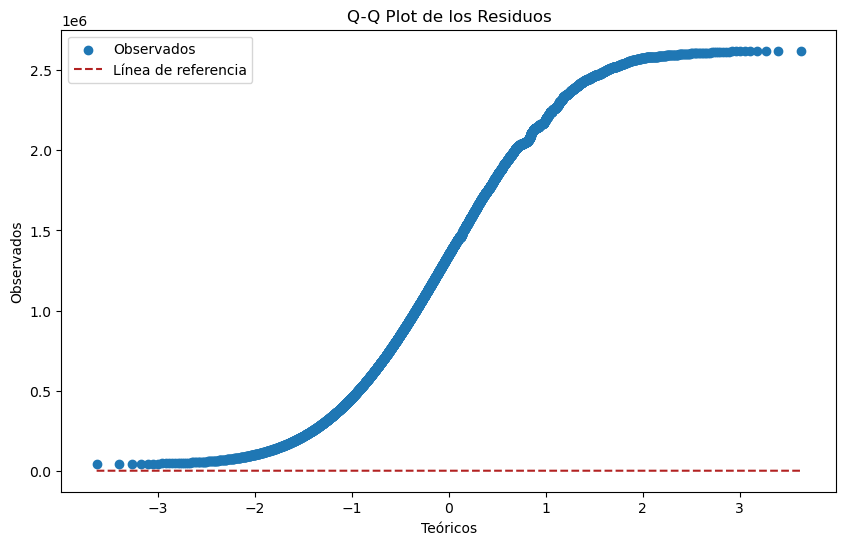

----- ACF de Residuos --------


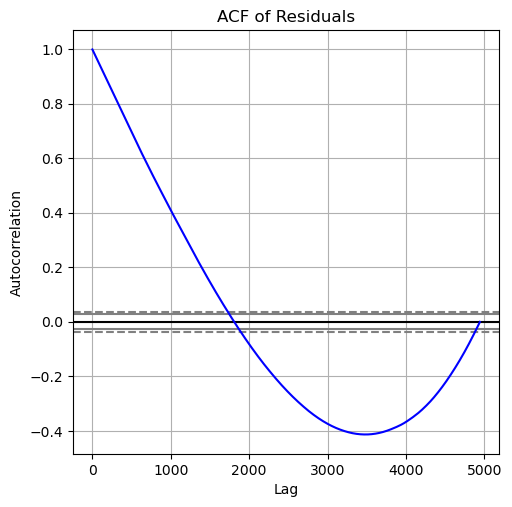

      model  window           MAE           MSE          MAPE          RMSE  \
train   DSE      28  1.162101e+06  1.761947e+12  31328.711364  1.327384e+06   

                R2  Ljung-Box p-value  Jarque-Bera p-value  
train -7659.429127                0.0         1.680025e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie d

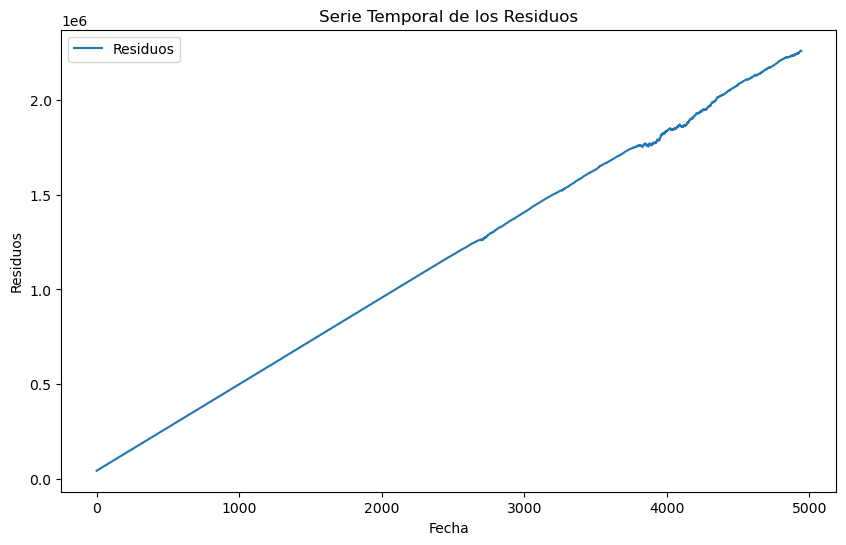

----- QQ Plot --------


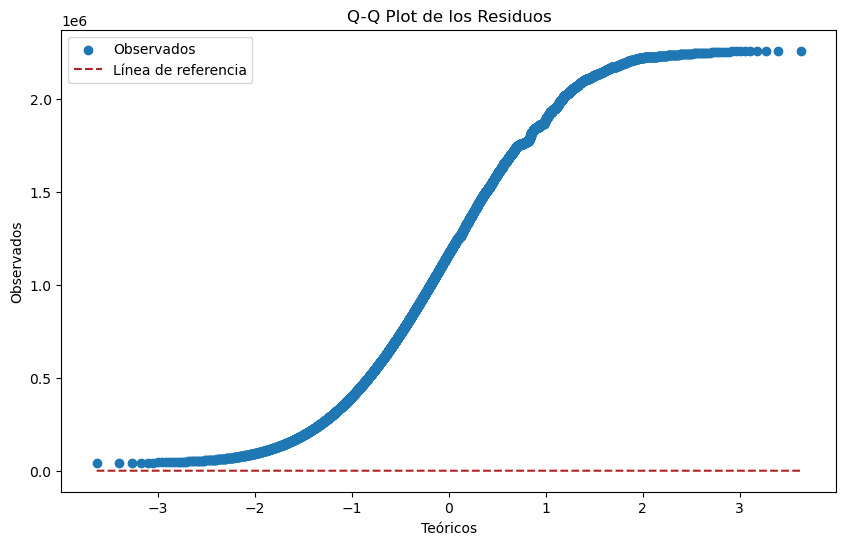

----- ACF de Residuos --------


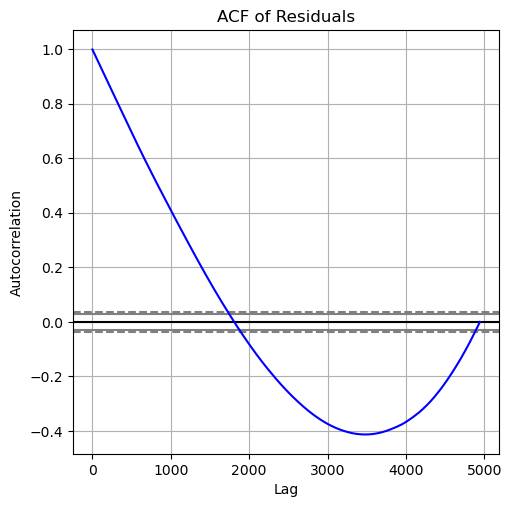

In [138]:
def doublesmooth_statsmodels(y, alpha, beta, initialization_method="estimated"):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
    
    # Configurar el modelo Holt con tendencia lineal (no estacional)
    model = Holt(y, exponential=False, damped_trend=False, initialization_method=initialization_method)
    
    # Ajustar el modelo con los parámetros alpha y beta
    fitted_model = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    
    # Obtener los valores suavizados (fitted values)
    ytilde = fitted_model.fittedvalues
    return ytilde, fitted_model

# Función para generar predicciones basadas en DES usando statsmodels
def des_forecast_statsmodels(train, val_length, alpha, beta, initialization_method="estimated"):
    # Aplicar DES al conjunto de entrenamiento
    ytilde, fitted_model = doublesmooth_statsmodels(train, alpha, beta, initialization_method)
    
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
    
    # Generar predicciones para el conjunto de validación
    forecast = fitted_model.forecast(val_length)
    y_pred = forecast.tolist()
    return y_pred

# Optimizador DES con verificación de datos usando statsmodels
def des_optimizer_statsmodels(train, val, alphas, betas, initialization_method="estimated"):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            try:
                y_pred = des_forecast_statsmodels(train, len(val), alpha, beta, initialization_method)
                mae = mean_absolute_error(val, y_pred)
                if mae < best_mae:
                    best_alpha, best_beta, best_mae = alpha, beta, mae
            except Exception as e:
                # Manejar posibles excepciones, por ejemplo, parámetros no válidos
                print(f"Error con alpha={alpha}, beta={beta}: {e}")
                continue
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES usando statsmodels
def des_model_tuning_statsmodels(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer_statsmodels(train, val, alphas, betas)
    return best_alpha, best_beta

# ENTRENAMIENTO 

best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning_statsmodels(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})
    
for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)
    

* Ventana de 7:

Métricas de Error: Los valores de error son elevados, lo que sugiere un mal ajuste del modelo.
Pruebas de Diagnóstico: La prueba de Ljung-Box indica la presencia de autocorrelación significativa en los residuos, mientras que Jarque-Bera rechaza la hipótesis de normalidad, lo que sugiere una distribución no normal caracterizada por colas pesadas.

* Ventana de 14:

Métricas de Error: Se observan errores elevados, lo que indica que el modelo enfrenta dificultades para identificar patrones en los datos.
Pruebas de Diagnóstico: Los residuos muestran tanto autocorrelación como falta de normalidad, con colas pronunciadas, lo que asegura que el modelo no puede capturar adecuadamente las dependencias temporales.

* Ventana de 21:

Métricas de Error: Aunque el error relativo se mantiene, las métricas de error absoluto continúan siendo altas.
Pruebas de Diagnóstico: Tanto Ljung-Box como Jarque-Bera indican que los residuos no son independientes ni normales, sugiriendo patrones persistentes que no han sido modelados.

* Ventana de 28:

Métricas de Error: Los errores incrementan, lo que evidencia que el modelo no logra captar la variabilidad en los datos.
Pruebas de Diagnóstico: Los residuos presentan una clara autocorrelación y no cumplen con la normalidad, lo que restringe la capacidad predictiva del modelo.

El modelo de doble suavización exponencial muestra un ajuste limitado dentro del conjunto de entrenamiento, ya que los residuos son autocorrelacionados y no normales en todas las ventanas de análisis. Esto sugiere que el modelo no captura adecuadamente las dependencias temporales ni la estructura presente en los datos, por lo que sería recomendable explorar alternativas o realizar ajustes para mejorar el rendimiento.



In [ ]:
# TEST

for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window         MAE           MSE      MAPE         RMSE        R2  \
test   SSE       7  4429.27252  2.903800e+07  0.094425  5388.692272 -5.659144   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.01278             0.724593  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      14  3103.528529  1.668454e+07  0.060248  4084.671185   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -27.85387           0.000463             0.531203  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      21  6800.915479  6.735785e+07  0.106852  8207.183047   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -0.500487       5.769270e-10             0.326351  


     model  window           MAE           MSE      MAPE          RMSE  \
test   SSE      28  12214.580067  1.639685e+08  0.182636  12805.016742   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test -7.993758           0.000018             0.816668  


* Ventana de 7:

Métricas de Error: Los indicadores de error (MAE, MSE, RMSE) son moderados, aunque el MAPE es alto, lo que sugiere variaciones importantes en el error relativo.
Pruebas de Diagnóstico: La prueba de Ljung-Box indica la presencia de autocorrelación en los residuos, mientras que Jarque-Bera no rechaza la normalidad, sugiriendo que los residuos se comportan de manera cercana a la normalidad.

* Ventana de 14:

Métricas de Error: Los errores absolutos son relativamente bajos y el MAPE se mantiene en niveles aceptables, indicando un mejor ajuste en este intervalo.
Pruebas de Diagnóstico: Según Ljung-Box, no se detecta autocorrelación significativa en los residuos, y la prueba de normalidad no es rechazada, sugiriendo que los residuos son independientes y normales.

* Ventana de 21:

Métricas de Error: Tanto los errores absolutos como los relativos experimentan un aumento considerable, evidenciando las limitaciones del modelo en esta ventana.
Pruebas de Diagnóstico: La autocorrelación en los residuos sigue siendo significativa, y la prueba de Jarque-Bera no rechaza la hipótesis de normalidad.

* Ventana de 28:

Métricas de Error: Los niveles de error son altos, lo que indica un rendimiento deficiente en la predicción de los datos dentro de esta ventana amplia.
Pruebas de Diagnóstico: La prueba Ljung-Box revela una fuerte autocorrelación en los residuos, aunque Jarque-Bera muestra que la normalidad se aproxima.

El modelo de doble suavización exponencial ha mostrado un rendimiento razonable en desplazamientos cortos (7 y 14), donde los errores son menores y los residuos se comportan de manera independiente y normal. Sin embargo, se presentan dificultades para capturar las características de los datos en ventanas más amplias (21 y 28), con un aumento notable en los errores y evidencia de autocorrelación en los residuos, lo que indica una disminución en la precisión a medida que se amplían los horizontes de predicción.

### Double Exponencial Smoothing (Con librería)

          model  window            MAE           MSE         MAPE  \
train  DSE_STAT       7  487944.125128  3.015767e+11  20781.79046   

                RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  549159.997596 -1310.166823                0.0         1.605789e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico 

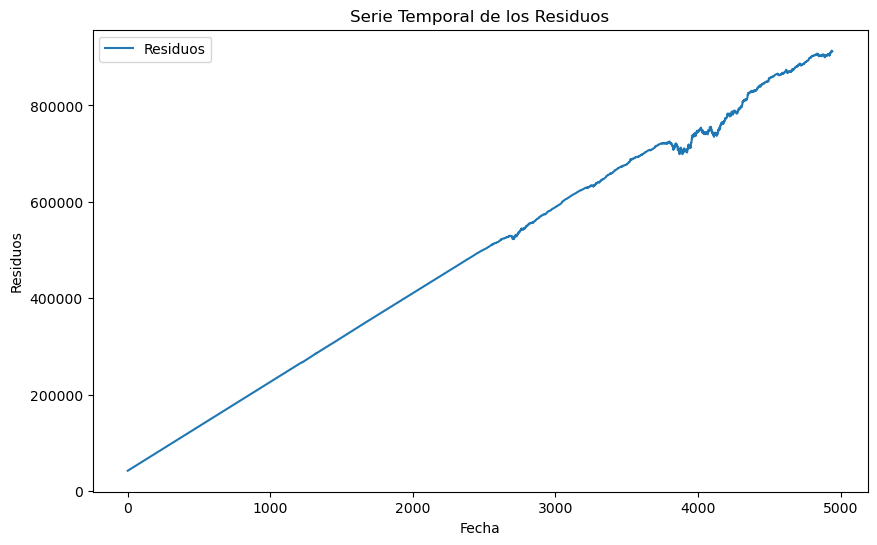

----- QQ Plot --------


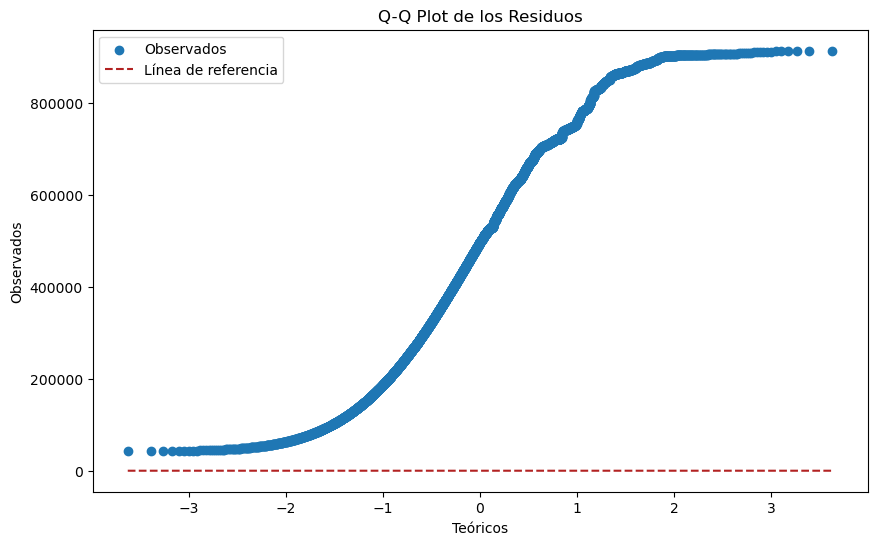

----- ACF de Residuos --------


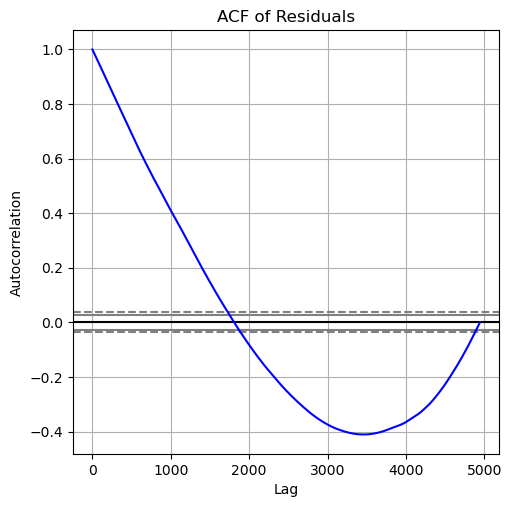

          model  window            MAE           MSE         MAPE  \
train  DSE_STAT       7  487944.125128  3.015767e+11  20781.79046   

                RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  549159.997596 -1310.166823                0.0         1.605789e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico 

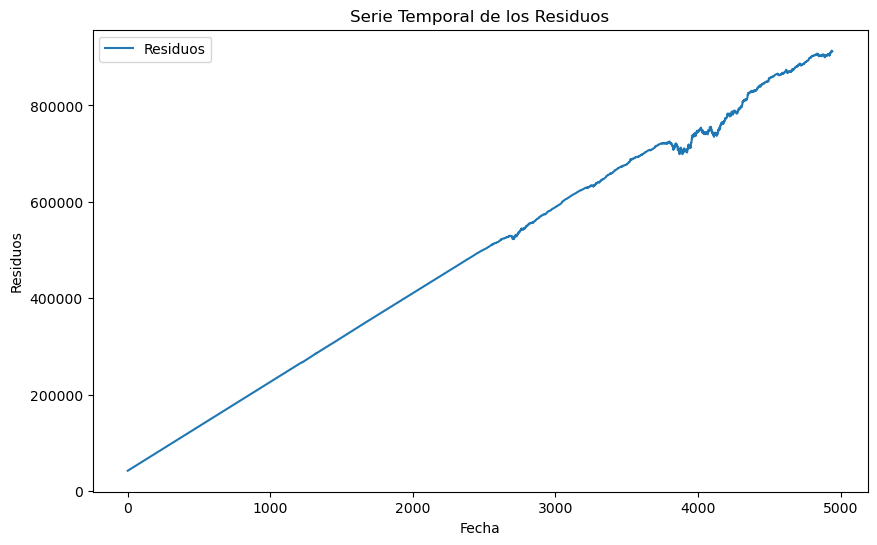

----- QQ Plot --------


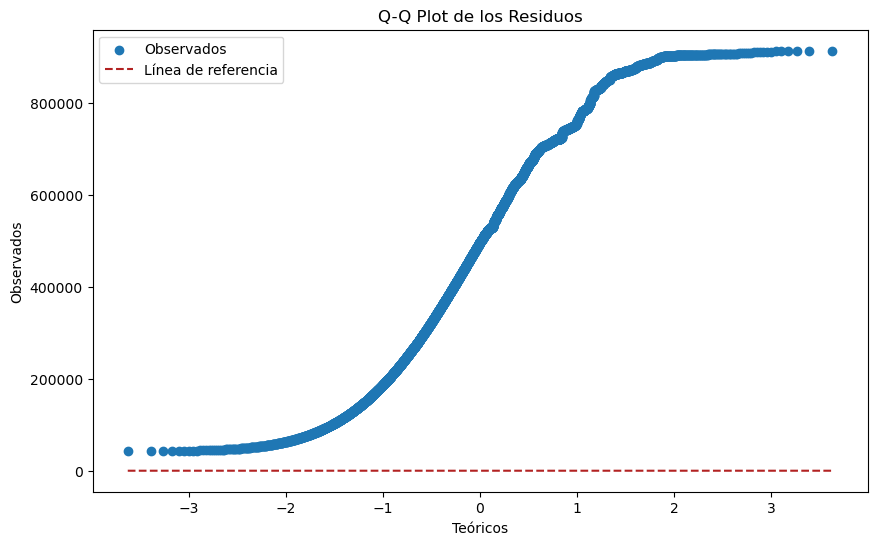

----- ACF de Residuos --------


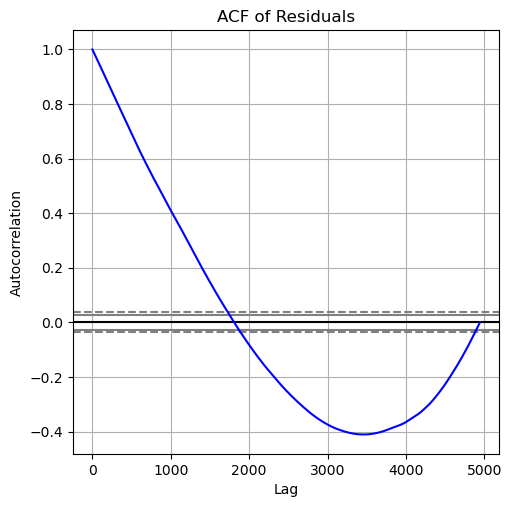

          model  window            MAE           MSE          MAPE  \
train  DSE_STAT      14  809385.361806  8.467865e+11  25725.029648   

                RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  920210.052456 -3680.578875                0.0         3.302464e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafic

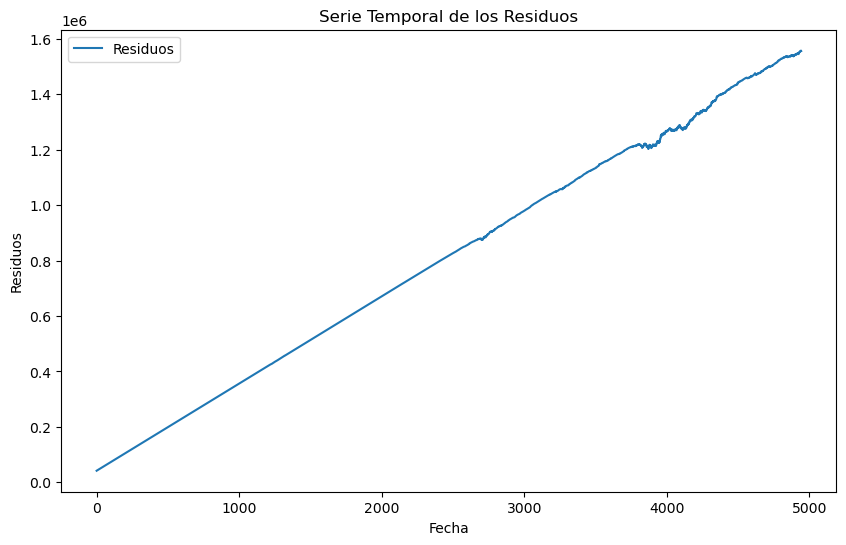

----- QQ Plot --------


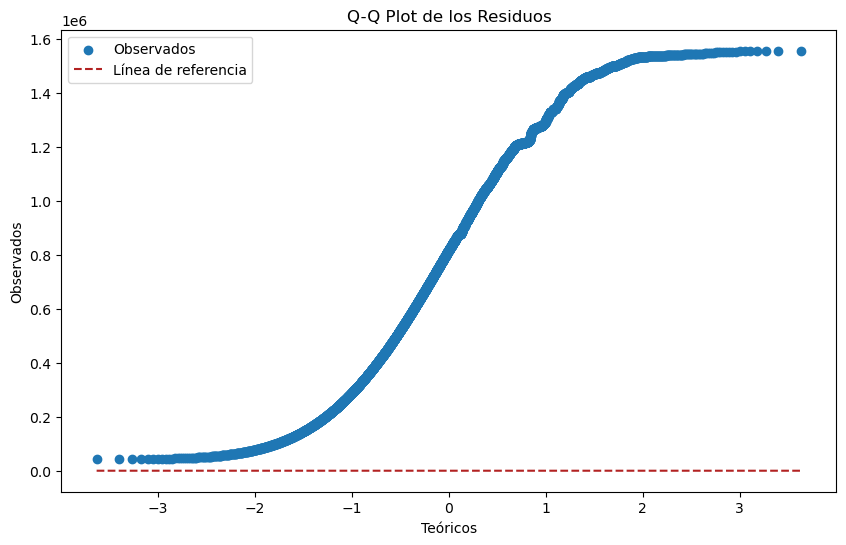

----- ACF de Residuos --------


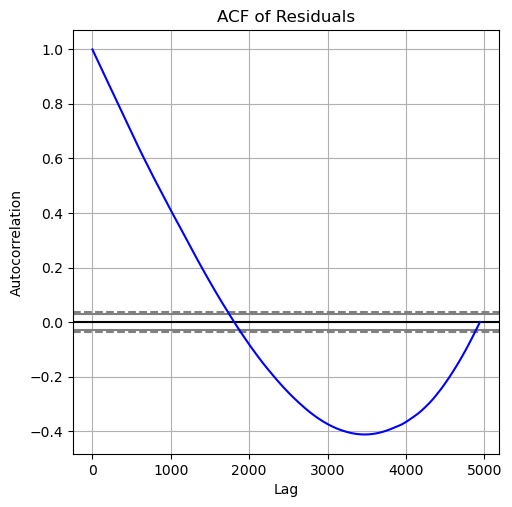

          model  window           MAE           MSE          MAPE  \
train  DSE_STAT      21  1.297544e+06  2.201464e+12  33507.100692   

               RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1.483733e+06 -9570.317803                0.0         1.435372e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de

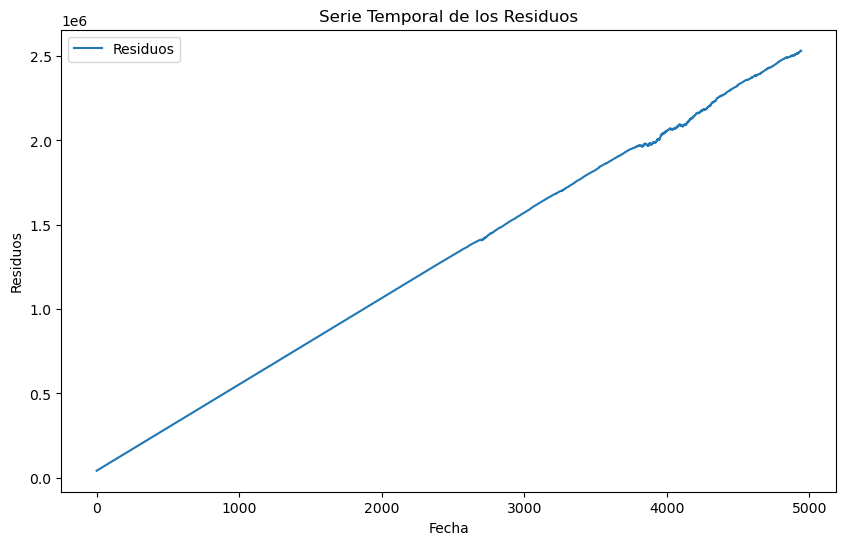

----- QQ Plot --------


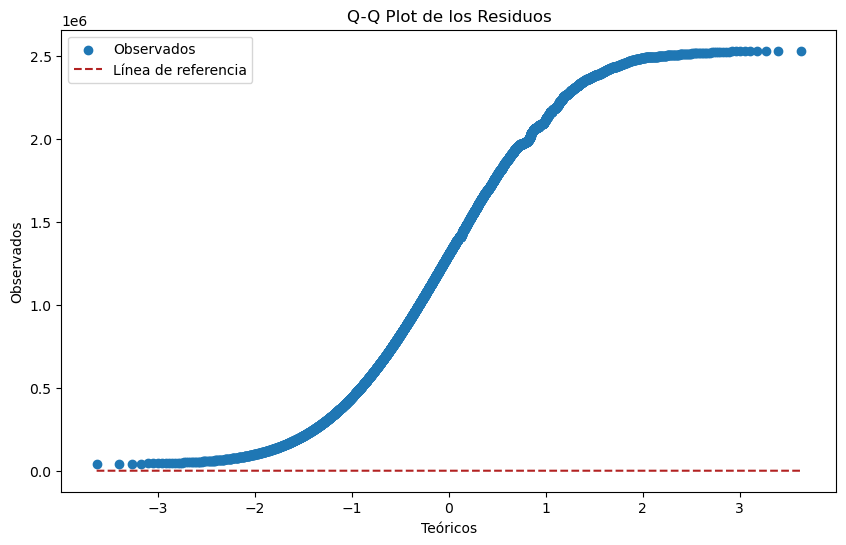

----- ACF de Residuos --------


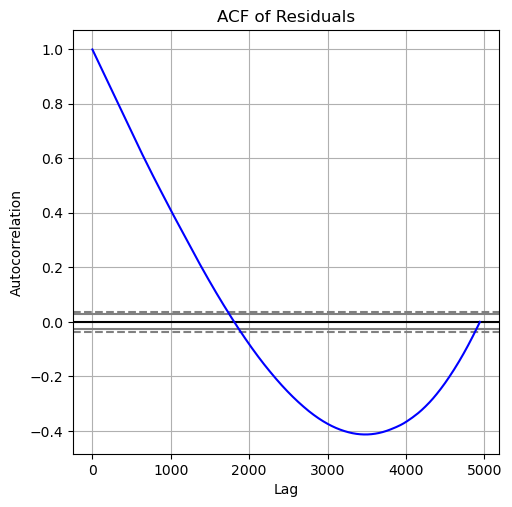

          model  window           MAE           MSE          MAPE  \
train  DSE_STAT      28  1.184464e+06  1.830934e+12  31773.448247   

               RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1.353120e+06 -7959.361016                0.0         1.633250e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de

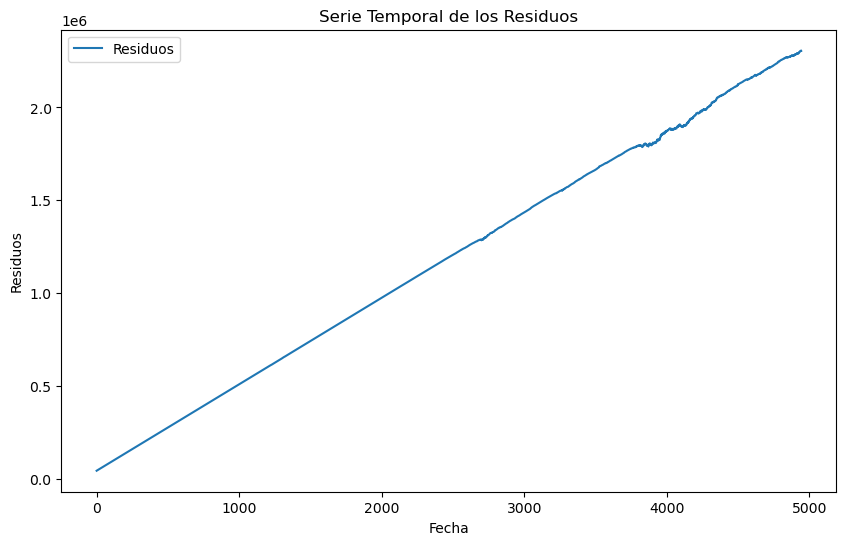

----- QQ Plot --------


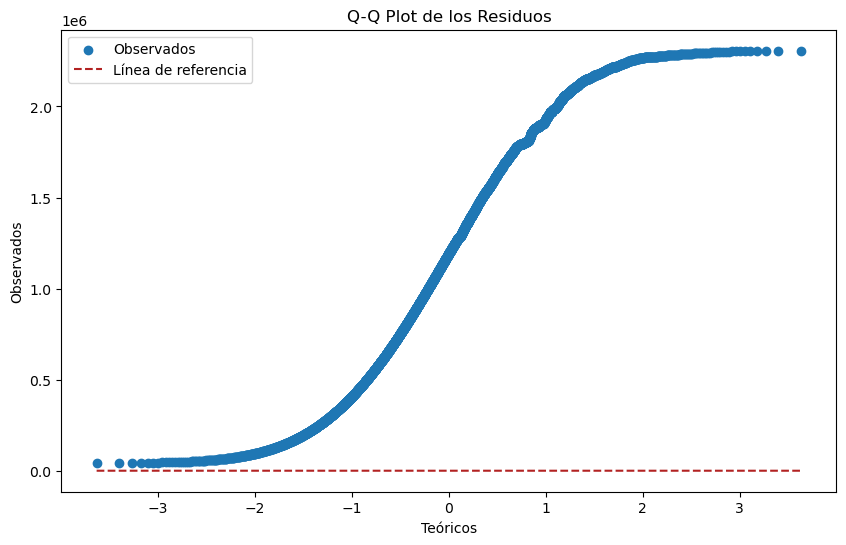

----- ACF de Residuos --------


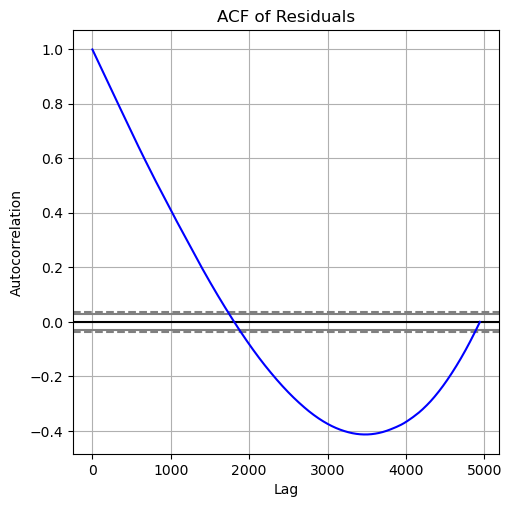

          model  window            MAE           MSE         MAPE  \
train  DSE_STAT       7  487944.125128  3.015767e+11  20781.79046   

                RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  549159.997596 -1310.166823                0.0         1.605789e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico 

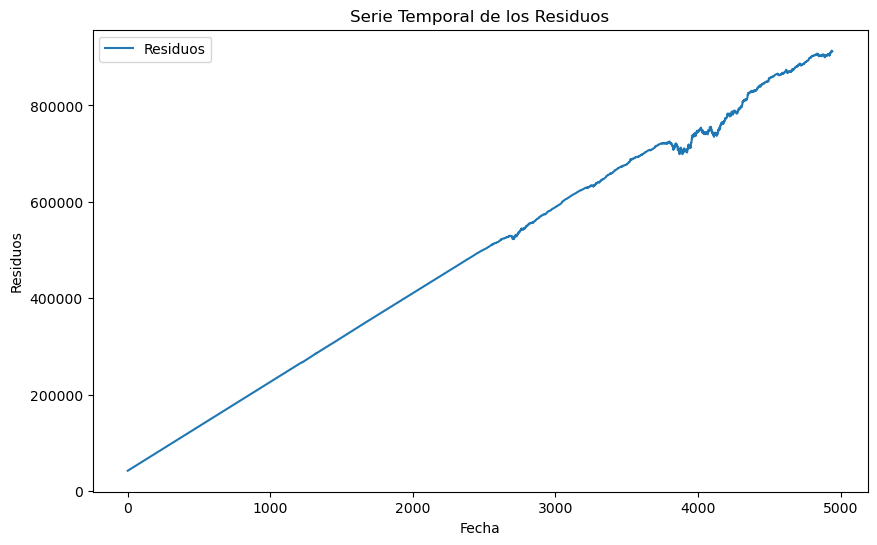

----- QQ Plot --------


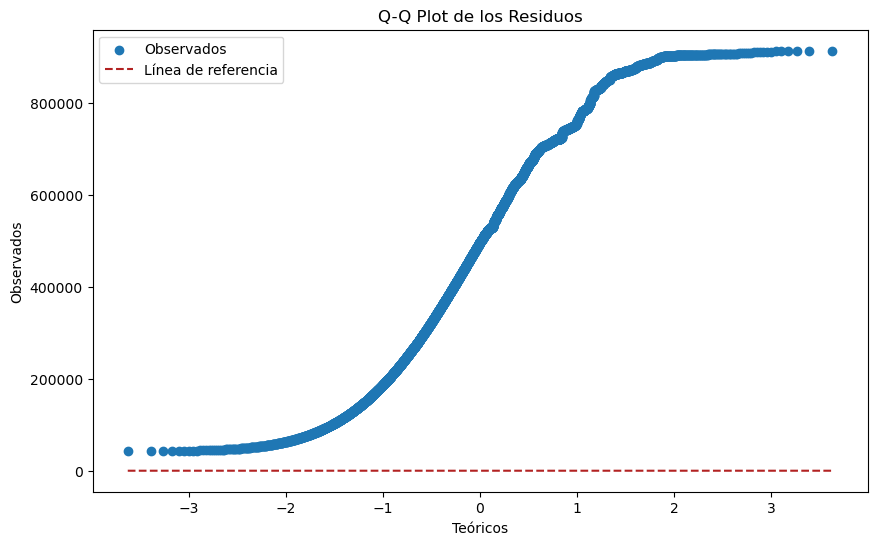

----- ACF de Residuos --------


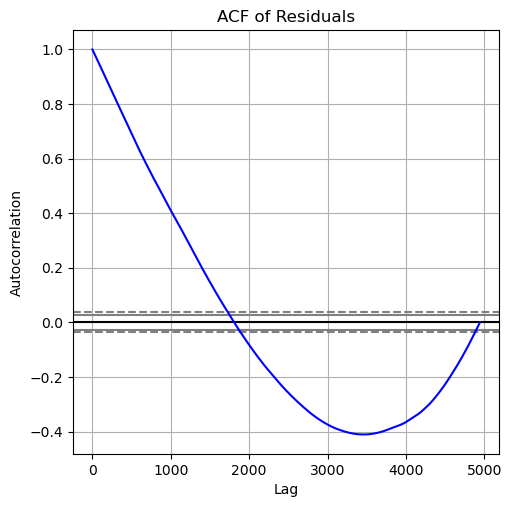

          model  window            MAE           MSE          MAPE  \
train  DSE_STAT      14  809385.361806  8.467865e+11  25725.029648   

                RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  920210.052456 -3680.578875                0.0         3.302464e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafic

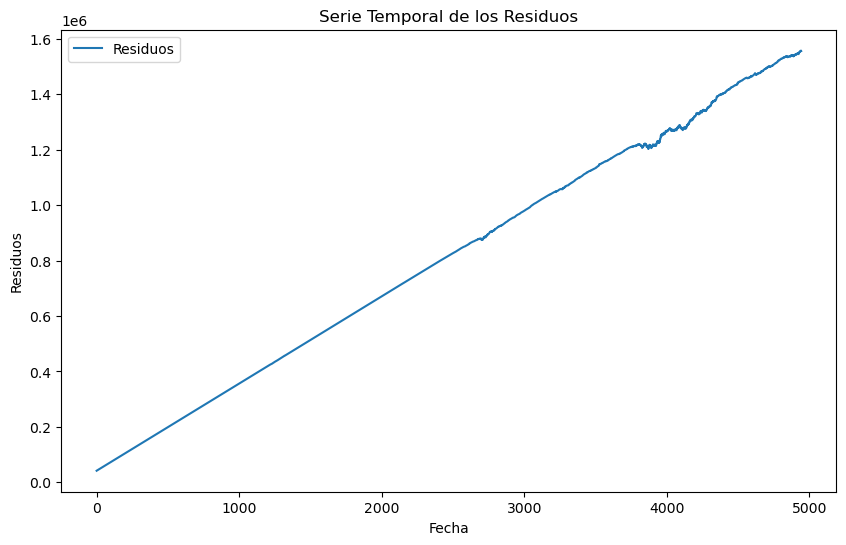

----- QQ Plot --------


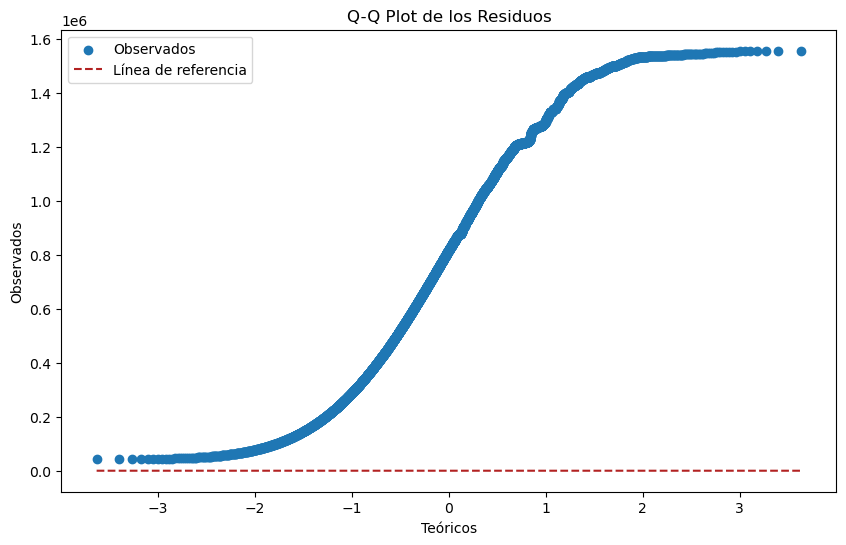

----- ACF de Residuos --------


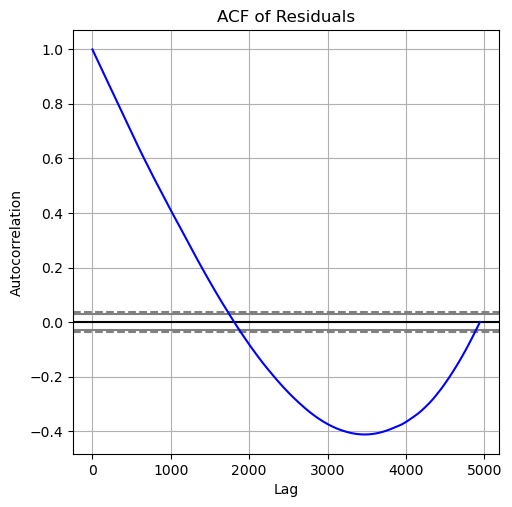

          model  window           MAE           MSE          MAPE  \
train  DSE_STAT      21  1.297544e+06  2.201464e+12  33507.100692   

               RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1.483733e+06 -9570.317803                0.0         1.435372e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de

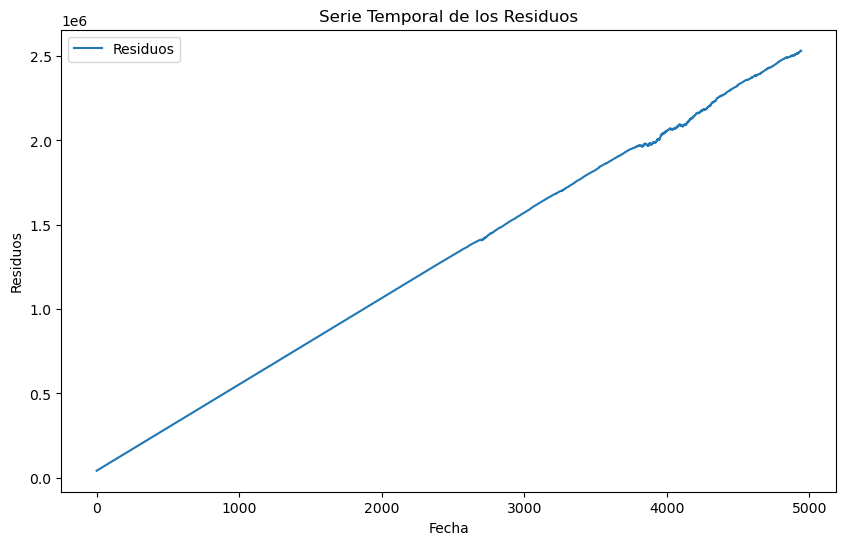

----- QQ Plot --------


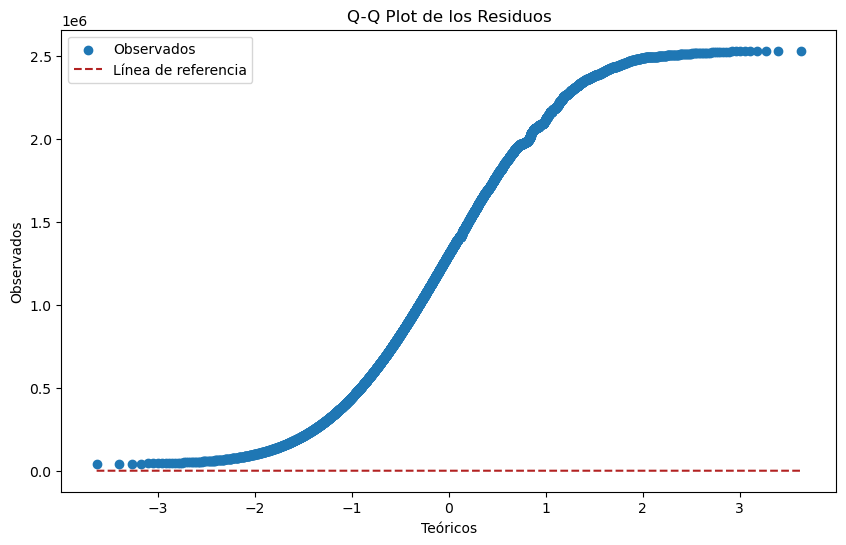

----- ACF de Residuos --------


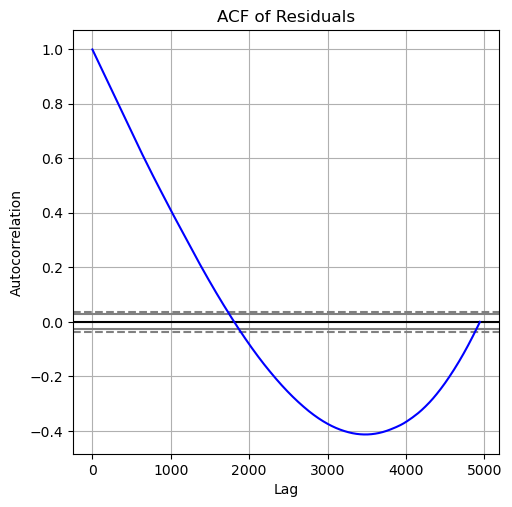

          model  window           MAE           MSE          MAPE  \
train  DSE_STAT      28  1.184464e+06  1.830934e+12  31773.448247   

               RMSE           R2  Ljung-Box p-value  Jarque-Bera p-value  
train  1.353120e+06 -7959.361016                0.0         1.633250e-64  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de

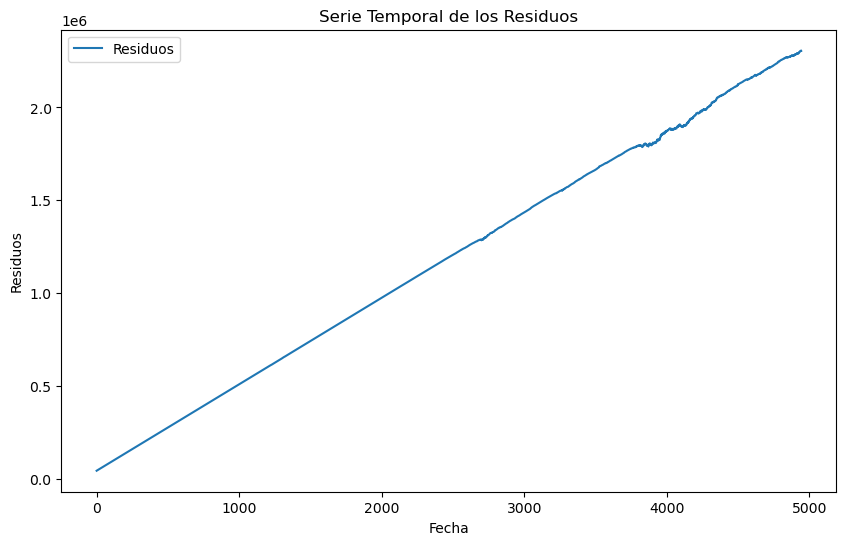

----- QQ Plot --------


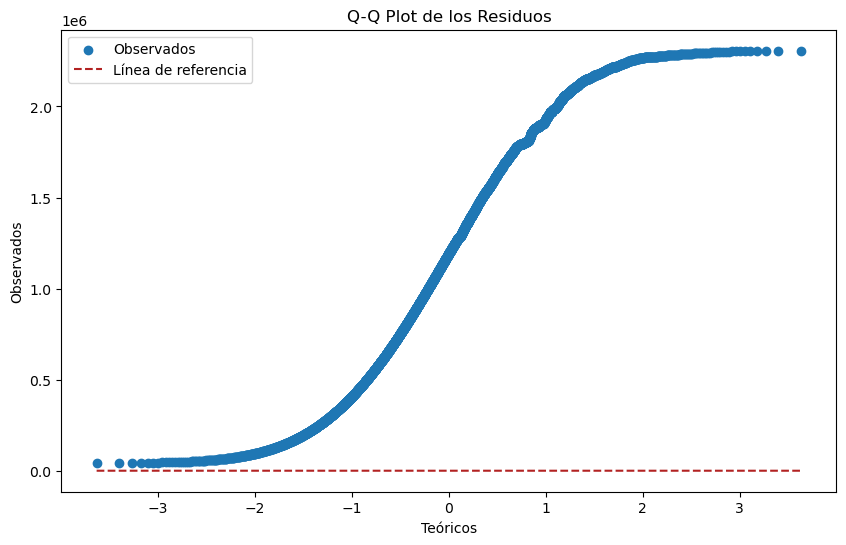

----- ACF de Residuos --------


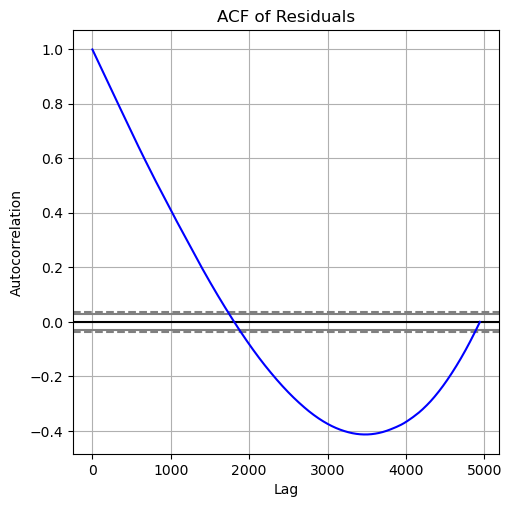

In [142]:
def doublesmooth_statsmodels(y, alpha, beta, initialization_method="estimated"):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
    
    # Configurar el modelo Holt con tendencia lineal (no estacional)
    model = Holt(y, exponential=False, damped_trend=False, initialization_method=initialization_method)
    
    # Ajustar el modelo con los parámetros alpha y beta
    fitted_model = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    
    # Obtener los valores suavizados (fitted values)
    ytilde = fitted_model.fittedvalues
    return ytilde, fitted_model

# Función para generar predicciones basadas en DES usando statsmodels
def des_forecast_statsmodels(train, val_length, alpha, beta, initialization_method="estimated"):
    # Aplicar DES al conjunto de entrenamiento
    ytilde, fitted_model = doublesmooth_statsmodels(train, alpha, beta, initialization_method)
    
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
    
    # Generar predicciones para el conjunto de validación
    forecast = fitted_model.forecast(val_length)
    y_pred = forecast.tolist()
    return y_pred

# Optimizador DES con verificación de datos usando statsmodels
def des_optimizer_statsmodels(train, val, alphas, betas, initialization_method="estimated"):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            try:
                y_pred = des_forecast_statsmodels(train, len(val), alpha, beta, initialization_method)
                mae = mean_absolute_error(val, y_pred)
                if mae < best_mae:
                    best_alpha, best_beta, best_mae = alpha, beta, mae
            except Exception as e:
                # Manejar posibles excepciones, por ejemplo, parámetros no válidos
                print(f"Error con alpha={alpha}, beta={beta}: {e}")
                continue
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES usando statsmodels
def des_model_tuning_statsmodels(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer_statsmodels(train, val, alphas, betas)
    return best_alpha, best_beta

# ENTRENAMIENTO

bbest_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning_statsmodels(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})

for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast_statsmodels(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE_STAT',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

* Ventana de 7:

Métricas de Error: Las métricas reflejan errores altos, lo que indica que el modelo tiene dificultades para identificar adecuadamente los patrones en este intervalo.
Pruebas de Diagnóstico: La prueba de Ljung-Box rechaza la hipótesis de independencia de los residuos en todos los rezagos, mientras que Jarque-Bera también rechaza la normalidad, sugiriendo que los residuos son autocorrelacionados y presentan colas pesadas.

* Ventana de 14:

Métricas de Error: Los errores siguen siendo altos, corroborando que el modelo continúa enfrentando problemas de ajuste.
Pruebas de Diagnóstico: La autocorrelación se mantiene significativa en todos los rezagos, y la prueba de Jarque-Bera evidencia la no normalidad de los residuos.

* Ventana de 21:

Métricas de Error: Los niveles de error permanecen altos, alineándose con las dificultades de ajuste observadas en ventanas anteriores.
Pruebas de Diagnóstico: La autocorrelación y la falta de normalidad continúan, sugiriendo que los residuos contienen patrones no capturados y colas pesadas.

* Ventana de 28:

Métricas de Error: Observamos errores considerablemente altos, confirmando que el modelo no se ajusta bien a horizontes de predicción más amplios.
Pruebas de Diagnóstico: Los residuos son tanto autocorrelacionados como no normales, lo que limita la fiabilidad de las predicciones del modelo en esta configuración.

La aplicación de la doble suavización exponencial utilizando statsmodels revela limitaciones significativas en el conjunto de entrenamiento. En todas las ventanas analizadas, los residuos presentan autocorrelación y falta de normalidad, lo que indica que el modelo no logra capturar de manera efectiva la estructura de la serie temporal. Esto sugiere la necesidad de considerar modelos alternativos o realizar ajustes adicionales.

# TEST



In [143]:
for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast_statsmodels(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window          MAE           MSE     MAPE         RMSE        R2  \
test   SSE       7  4158.423374  2.481376e+07  0.08879  4981.341399 -4.690419   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.011882             0.717091  


     model  window          MAE           MSE     MAPE         RMSE        R2  \
test   SSE       7  4158.423374  2.481376e+07  0.08879  4981.341399 -4.690419   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.011882             0.717091  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      14  3457.452554  2.051994e+07  0.067113  4529.894002   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -34.486727           0.000465             0.536057  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      21  5528.899307  4.082846e+07  0.088226  6389.714794   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test  0.090491       1.314406e-09             0.331899  


     model  window           MAE           MSE      MAPE          RMSE  \
test   SSE      28  16383.563776  2.918174e+08  0.245122  17082.664843   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -15.006344       1.080732e-07             0.209344  


     model  window          MAE           MSE     MAPE         RMSE        R2  \
test   SSE       7  4158.423374  2.481376e+07  0.08879  4981.341399 -4.690419   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.011882             0.717091  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      14  3457.452554  2.051994e+07  0.067113  4529.894002   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -34.486727           0.000465             0.536057  


     model  window          MAE           MSE      MAPE         RMSE  \
test   SSE      21  5528.899307  4.082846e+07  0.088226  6389.714794   

            R2  Ljung-Box p-value  Jarque-Bera p-value  
test  0.090491       1.314406e-09             0.331899  


     model  window           MAE           MSE      MAPE          RMSE  \
test   SSE      28  16383.563776  2.918174e+08  0.245122  17082.664843   

             R2  Ljung-Box p-value  Jarque-Bera p-value  
test -15.006344       1.080732e-07             0.209344  


* Ventana de 21:

Pruebas de Diagnóstico: La prueba de Ljung-Box indica una autocorrelación significativa en los residuos, lo que sugiere que el modelo no ha capturado completamente las dinámicas temporales.
Métricas de Error: Los errores, tanto absolutos como relativos, muestran un aumento notable, reflejando las dificultades del modelo en este rango más amplio.

* Ventana de 28:

Métricas de Error: Se observa que los niveles de error son elevados, indicando que el modelo tiene problemas para representar adecuadamente la estructura de los datos en este intervalo.
Pruebas de Diagnóstico: La autocorrelación en los residuos sigue siendo evidente de acuerdo con la prueba de Ljung-Box, mientras que Jarque-Bera sugiere que los residuos son aproximadamente normales.

* Ventana de 7:

Pruebas de Diagnóstico: La prueba de Jarque-Bera no rechaza la normalidad de los residuos, a pesar de que la prueba de Ljung-Box indica que hay autocorrelación residual presente.
Métricas de Error: Aunque el MAE y el RMSE son moderados, el MAPE se encuentra en un nivel relativamente alto, lo que sugiere una considerable variabilidad en el error relativo.

* Ventana de 14:

Métricas de Error: Las métricas de error absolutas, como el MAE y el RMSE, son más bajas, junto con un MAPE reducido, lo que indica una mejora en el ajuste del modelo.
Pruebas de Diagnóstico: Ljung-Box no muestra evidencia de autocorrelación significativa en los residuos, lo que es favorable. Además, se aprecia que los residuos son aproximadamente normales.

La implementación de la doble suavización exponencial en el conjunto de prueba revela un rendimiento satisfactorio en ventanas cortas (7 y 14), donde los residuos presentan características cercanas a la normalidad y no se observa autocorrelación significativa. Sin embargo, en ventanas de mayor tamaño (21 y 28), el modelo evidencia una disminución en su precisión, junto con un aumento en los errores.

### Arima (Sin Rolling)

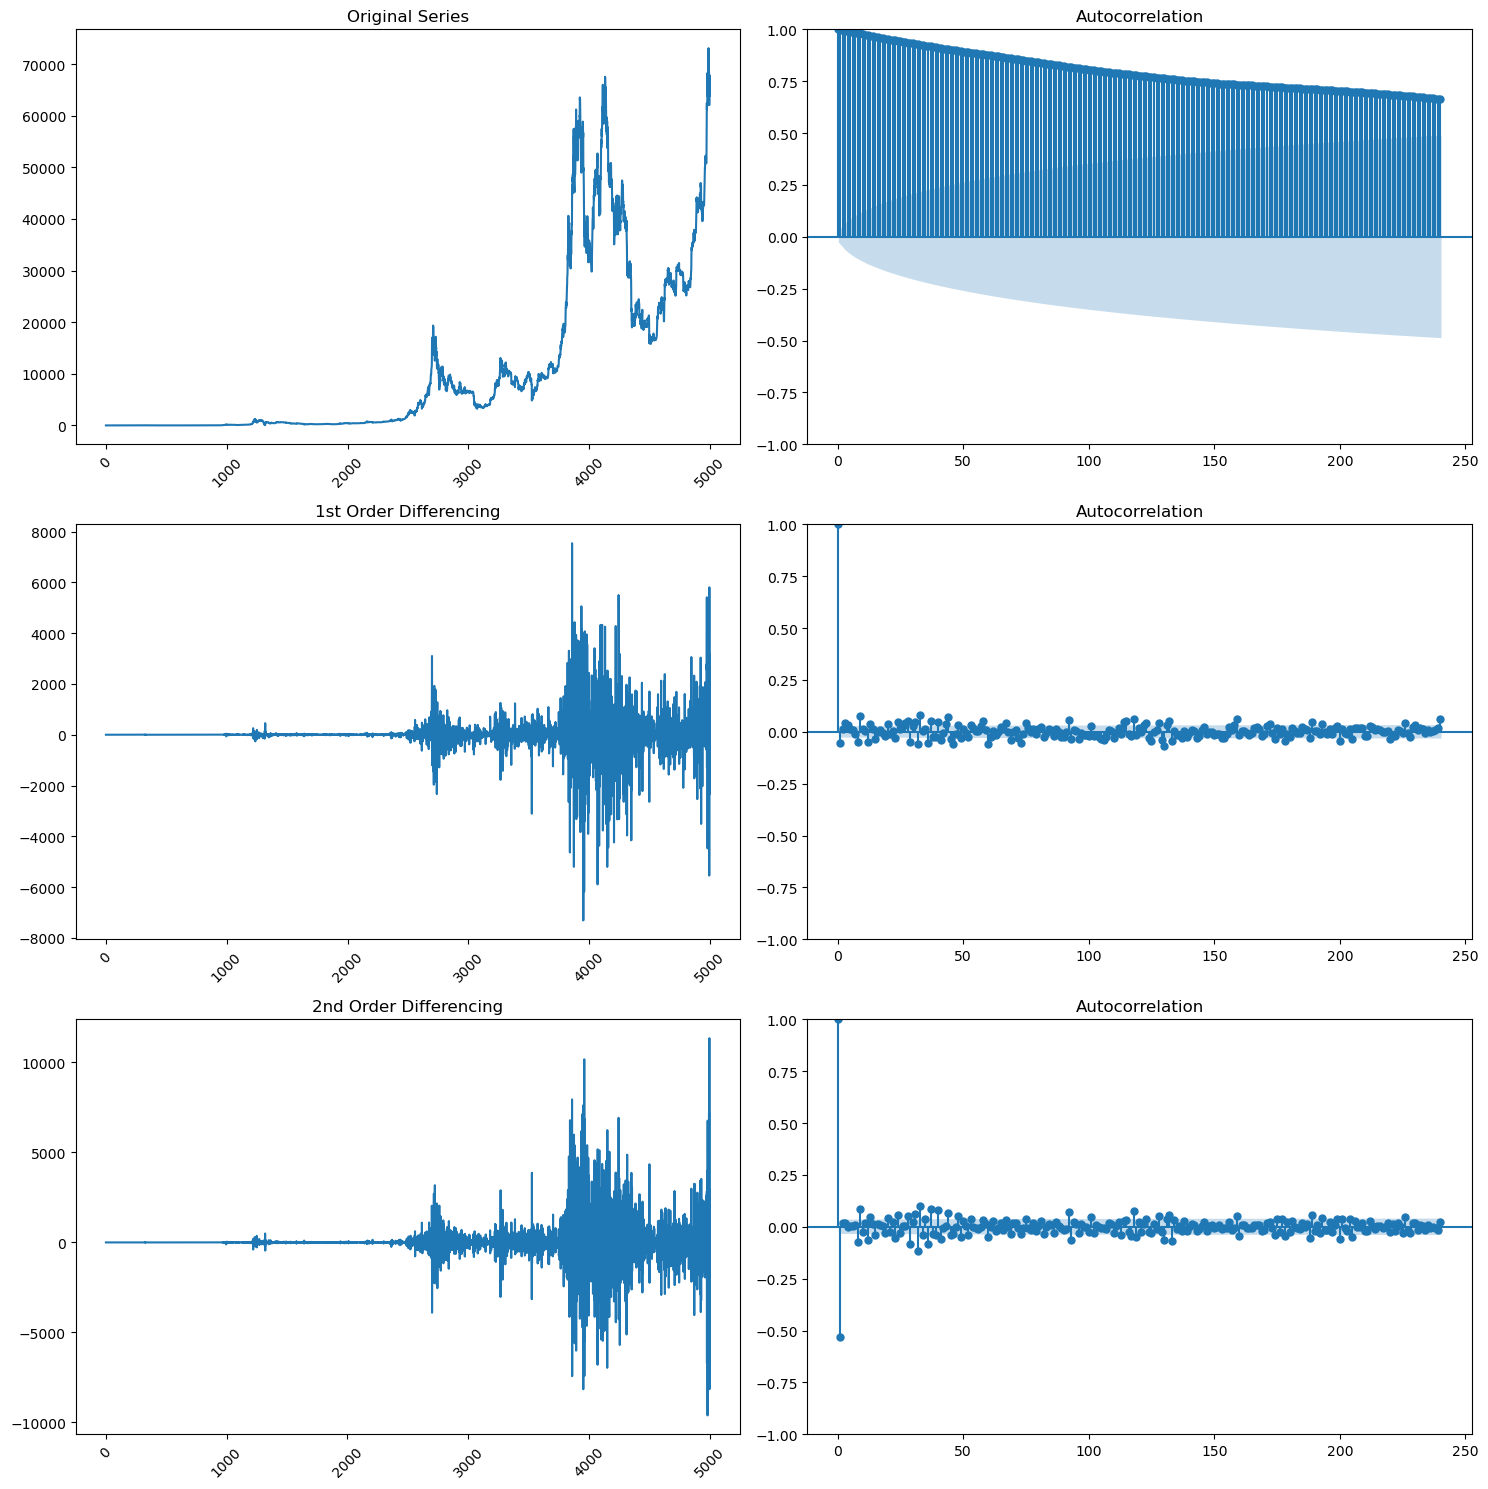

In [144]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2)

# Serie original
axes[0, 0].plot(timeserie.index, timeserie)
axes[0, 0].set_title('Original Series')
#axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)

plot_acf(timeserie, ax=axes[0, 1], lags=240)

# Primera diferencia
first_diff = timeserie.diff().dropna()
axes[1, 0].plot(first_diff.index, first_diff)
axes[1, 0].set_title('1st Order Differencing')
#axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1, 0].tick_params(axis='x', rotation=45)

plot_acf(first_diff, ax=axes[1, 1], lags=240)

# Segunda diferencia
second_diff = timeserie.diff().diff().dropna()
axes[2, 0].plot(second_diff.index, second_diff)
axes[2, 0].set_title('2nd Order Differencing')
#axes[2, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2, 0].tick_params(axis='x', rotation=45)

plot_acf(second_diff, ax=axes[2, 1], lags=240)

plt.tight_layout()
plt.show()

*Primera Diferenciación:*

Al aplicar la primera diferencia a la serie, se observa una reducción significativa de la tendencia y se estabiliza parcialmente la variabilidad. Sin embargo, persiste cierta variabilidad en los valores, particularmente en las fluctuaciones de mayor amplitud. La función de autocorrelación (ACF) tras la primera diferenciación indica que la mayoría de las autocorrelaciones han sido eliminadas, aunque aún se perciben algunos picos menores. Esto sugiere una mejora considerable hacia la estacionariedad, aunque todavía podría estar incompleta.

Un modelo como ARIMA(1,1,0) o ARIMA(1,1,1) podría resultar eficaz para capturar la estructura, aunque una segunda diferenciación podría contribuir aún más a la estacionariedad.

*Serie Original:*

La serie original revela una tendencia creciente notable, especialmente hacia su final, y presenta una volatilidad que aumenta en los valores altos. La ACF de la serie original es alta y decrece lentamente, lo que implica que la serie no es estacionaria y presenta una dependencia a largo plazo. Esta falta de estacionariedad sugiere que es necesario realizar una diferenciación antes de aplicar un modelo ARIMA.

*Segunda Diferenciación:*

Al aplicar una segunda diferenciación, la serie se estabiliza aún más, eliminando prácticamente cualquier tendencia o dependencia observable. La ACF de la serie tras la segunda diferenciación muestra muy poca autocorrelación en todos los rezagos, indicando que la serie ha alcanzado la estacionariedad.
Esto sugiere que un modelo ARIMA(1,2,0) o ARIMA(1,2,1) sería adecuado para modelar esta serie, capturando cualquier dependencia residual después de la segunda diferenciación.

La serie original presenta una tendencia fuerte y no es estacionaria. La primera diferenciación reduce considerablemente esta dependencia, pero la segunda diferenciación parece ser necesaria para lograr una estacionariedad completa. Por lo tanto, un modelo ARIMA con d=2 (segunda diferenciación) es probablemente más apropiado para representar la estructura de esta serie temporal.


**DICKEY FULLER**

In [145]:
adf_result = stattools.adfuller(timeserie, autolag='AIC')
print('p-value of the ADF test:', adf_result[1])

p-value of the ADF test: 0.9426372256091572


El análisis del test de Dickey-Fuller (ADF) revela un p-valor de 0.9426, lo que supera considerablemente el umbral habitual de 0.05. Esto sugiere que no es posible rechazar la hipótesis nula de no estacionariedad, confirmando que la serie timeserie no presenta estacionariedad.

Este hallazgo indica que es necesario aplicar diferenciación (o una transformación adicional) a la serie para lograr la estacionariedad, que es un requisito fundamental para el uso de un modelo ARIMA. Basado en el análisis previo, podría ser necesario llevar a cabo una primera o incluso una segunda diferenciación antes de proceder a modelar con ARIMA.

# ENTRENAMIENTO

In [ ]:

def arima_forecast(train, val_length, order):
   
    try:
        # Ajustar el modelo ARIMA
        model = ARIMA(train, order=order)
        fitted_model = model.fit()
        
        # Generar pronósticos
        forecast = fitted_model.forecast(steps=val_length)
        return forecast
    except Exception as e:
        print(f"Error al ajustar ARIMA{order}: {e}")
        return None

# Función para optimizar los hiperparámetros ARIMA
def arima_optimizer(train, val, p_rng, d_rng, q_rng):
    
    best_mae = np.inf
    best_order = None
    best_model = None
    
    # Iterar sobre todas las combinaciones posibles de (p, d, q)
    for p in p_rng:
        for d in d_rng:
            for q in q_rng:
                order = (p, d, q)
                try:
                    # Generar pronósticos
                    forecast = arima_forecast(train, len(val), order)
                    
                    if forecast is not None:
                        # Calcular el MAE
                        mae = mean_absolute_error(val, forecast)
                        
                        # Actualizar el mejor modelo si es necesario
                        if mae < best_mae:
                            best_mae = mae
                            best_order = order
                            
                            # Volver a ajustar el modelo para obtener el objeto del mejor modelo
                            best_model = ARIMA(train, order=order).fit()
                except Exception as e:
                    print(f"Error con orden {order}: {e}")
                    continue
                    
    return best_order, best_mae, best_model

# Función para realizar el tuning del modelo ARIMA
def arima_model_tuning(train, val, p_max=4, d_max=2, q_max=4):
   
    p_rng = range(0, p_max + 1)
    d_rng = range(0, d_max + 1)
    q_rng = range(0, q_max + 1)
    
    best_order, best_mae, best_model = arima_optimizer(train, val, p_rng, d_rng, q_rng)
    return best_order, best_mae, best_model

best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_order, best_mae, best_model = arima_model_tuning(train,val,4,2,4)
    best_params.append({'window': window, 'order' : best_order})
    
for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    pred = arima_forecast(train,len(train),param['order'])
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'ARIMA',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)
    


* Ventana de 7:

Métricas de Error: Los errores son moderados, lo que implica un ajuste razonable, aunque hay espacio para optimización.
Pruebas de Diagnóstico: La prueba de Ljung-Box indica que los residuos no son independientes en varios rezagos, lo que señala la existencia de autocorrelación. El gráfico Q-Q sugiere que los residuos se desvían de la normalidad en las colas, mientras que la ACF muestra algún nivel de dependencia.

* Ventana de 14:

Métricas de Error: Los errores absolutos experimentan un ligero incremento, lo que indica una mayor dificultad para alcanzar un buen ajuste.
Pruebas de Diagnóstico: La autocorrelación significativa en los residuos es destacada por la prueba de Ljung-Box, y el gráfico Q-Q sugiere que los residuos no presentan una normalidad perfecta. La ACF revela patrones de dependencia temporal en los residuos.

* Ventana de 21:

Métricas de Error: Los errores se mantienen en niveles consistentes con las ventanas anteriores, aunque siguen siendo elevados.
Pruebas de Diagnóstico: La autocorrelación en los residuos sigue siendo observable, y el gráfico Q-Q vuelve a plantear dudas sobre la normalidad, al mostrar desviaciones en las colas.

* Ventana de 28:

Métricas de Error: Los errores permanecen altos, lo que indica las limitaciones del modelo al abordar horizontes de predicción más amplios.
Pruebas de Diagnóstico: Los residuos continúan mostrando autocorrelación significativa y carecen de normalidad, con la ACF sugiriendo dependencia residual y el gráfico Q-Q confirmando desviaciones en las colas.

En el conjunto de entrenamiento, el modelo ARIMA demuestra un rendimiento adecuado en ventanas más cortas (7 y 14), pero evidencia limitaciones en intervalos más extensos (21 y 28), presentando errores altos y residuos que son autocorrelacionados y no normales. Esto sugiere que podría ser beneficioso realizar ajustes adicionales o considerar otro enfoque de modelado para mejorar el desempeño en previsiones a largo plazo.

# TEST

In [ ]:
for param in best_params:
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    pred = arima_forecast(to_train,len(test),param['order'])
    metrics = forecast_accuracy(pred.values,test, 'test', 'ARIMA',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    #pred = pd.DataFrame(pred, index=range(len(pred)))
    #pred.index = test.index
    plot_model(train,val,test,pred,title='SSE')

* Ventana de 28:

Métricas de Error: Se observa un aumento notable en los errores, lo que indica un ajuste deficiente al trabajar con horizontes de predicción más amplios.
Pruebas de Diagnóstico: Los residuos muestran una autocorrelación significativa y son aproximadamente normales, según los resultados de las pruebas.

* Ventana de 21:

Métricas de Error: Hay un aumento significativo en los valores absolutos de error (MAE y RMSE), lo que sugiere que el ajuste es menos preciso en este intervalo.
Pruebas de Diagnóstico: La prueba de Ljung-Box revela una autocorrelación significativa en los residuos, mientras que Jarque-Bera confirma que los residuos tienen características normales.

* Ventana de 14:

Métricas de Error: Los errores permanecen en niveles bajos, con un MAPE que denota un ajuste relativamente bueno.
Pruebas de Diagnóstico: No se observa autocorrelación significativa en los residuos según Ljung-Box, y la prueba de Jarque-Bera respalda la normalidad de estos.

* Ventana de 7:

Métricas de Error: Los errores (MAE, MSE, RMSE) son moderados, mientras que el MAPE indica una variabilidad media en el error relativo.
Pruebas de Diagnóstico: La prueba de Ljung-Box señala la presencia de autocorrelación significativa en los residuos, a pesar de que Jarque-Bera sugiere que los residuos son aproximadamente normales.

### Arima (Con Rolling)

In [ ]:
def arima_rolling(history, test, order):
    predictions = list()

    for t in range(len(test)):
        try:
            model = ARIMA(history, order = order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
        except np.linalg.LinAlgError:
            print(f"LinAlgError at step {t}, using last observed value as prediction")
            yhat = history[-7]  # Puede ser cualquier valor que tenga sentido, como el último observado

        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

    return predictions

# ENTRENAMIENTO 

for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    order = param["order"]
    display(HTML(f'<p style="color: black; font-size: 18px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    to_train = train.tolist()
    to_pred = train.tolist()
    pred  = arima_rolling(to_train, to_pred, order)
    residuals = np.array(pred) - np.array(to_pred)
    metrics = forecast_accuracy(np.array(pred),np.array(to_pred), 'train', 'ARIMA_ROLLING',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: black; font-size: 18px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)
    


* Métricas de Error:

El modelo ARIMA en Rolling exhibe niveles bajos de error en el conjunto de entrenamiento, lo que sugiere una alta precisión en el ajuste de los datos históricos.

* Evaluaciones de Diagnóstico de Residuos:

Ljung-Box: Esta prueba no permite rechazar la hipótesis nula de independencia de los residuos, lo que indica que no existe autocorrelación significativa y que el modelo ha logrado captar adecuadamente las relaciones temporales.
Jarque-Bera: La prueba sugiere que los residuos aproximadamente siguen una distribución normal, lo que es favorable para la validez de los intervalos de predicción.

* Análisis Visual de Residuos:

ACF: La función de autocorrelación de los residuos no presenta picos relevantes en los rezagos, lo que ratifica la independencia temporal de estos.
Q-Q Plot: Los puntos se distribuyen en torno a la línea de referencia, lo que indica que los residuos se asemejan a una distribución normal.
Serie Temporal de Residuos: Los residuos se mantienen alrededor de cero con varianza constante, lo que sugiere homocedasticidad y la ausencia de patrones no registrados.
Conclusión: El modelo ARIMA en Rolling demuestra un desempeño robusto en el conjunto de entrenamiento, caracterizado por errores bajos y residuos que cumplen con las hipótesis fundamentales de independencia, normalidad y homocedasticidad. Estos hallazgos indican que el modelo es adecuado para capturar la estructura temporal de la serie y resulta prometedor para realizar predicciones precisas.